# **Must have git lfs installed to properly download and run all files**

https://git-lfs.com

# **Imports and importing the data**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import os

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify
[nltk_data]     failed: unable to get local issuer certificate
[nltk_data]     (_ssl.c:1002)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>


In [2]:
rateMyProfData = pd.read_csv('Cleaned_UW_RMP.csv')
rateMyProfData.head()

,Review-Body,Date,Course-Name,Course-Number,For-Credit,Attendance,Take-Again,Grade,Textbook,Quality,Difficulty
0,"It's not hard class, but don't expect the 4.0....",2015-03-08,BUS,340.0,Yes,NaN,NaN,NaN,Yes,2.0,2.0
1,Syllabus was clear on what the daily homework ...,2016-02-21,BCUSP,202.0,Yes,NaN,NaN,NaN,Yes,2.5,3.0
2,Bridge is the coolest prof I've ever had. His ...,2023-11-20,BME,221.0,Yes,Not Mandatory,Yes,NaN,Yes,5.0,2.0
3,Bridge makes it abundantly clear what you need...,2020-08-22,ME,341.0,Yes,Not Mandatory,Yes,NaN,Yes,5.0,3.0
4,One of the best professors I have ever had. Tr...,2020-04-22,BENGR,321.0,Yes,Mandatory,Yes,NaN,Yes,5.0,3.0


# **Data Exploration**

## **Further Data Checking and Cleaning**

In [3]:
# See the null values by each row
rateMyProfData.isnull().sum()

Review-Body         1
Date                0
Course-Name        83
Course-Number     522
For-Credit       7905
Attendance       7921
Take-Again       8836
Grade            8970
Textbook         2649
Quality             0
Difficulty          0
dtype: int64

In the above cell, we can see there are a significant number of null values in the columns that are optional for users when leaving a review. Due to the sheer number of null values, This information is not neccessary or useful. We will drop these for the rest of our analysis.

In [4]:
rateMyProfData.drop(columns=['For-Credit', 
                         'Attendance', 
                         'Take-Again', 
                         'Grade', 
                         'Textbook'], inplace=True)

Further we need to deal with the null values that are still in place. For the review body, there is only one null value, and the review body is necessary so we will drop this row.

In [5]:
rateMyProfData = rateMyProfData.dropna(subset=['Review-Body'])

And finally, we chose to drop rows with null values course name and number, to keep the data from those for some interesting analysis later.

In [6]:
rateMyProfData = rateMyProfData.dropna(subset=['Course-Name', 'Course-Number'])
rateMyProfData['Course-Number'] = [str(num)[0] for num in rateMyProfData['Course-Number']] 
# user input data is all over the place, 
# take the first digit for the class year, ie 1 = 100 level, 4 = 400 level.


## **Data Analysis**

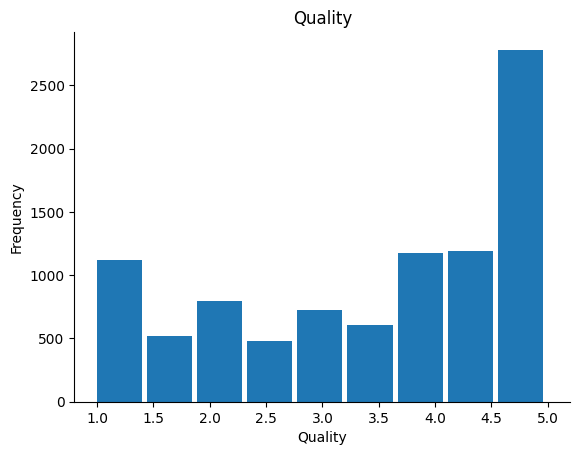

In [7]:
rateMyProfData['Quality'].plot(kind='hist', bins=9, title='Quality', align='mid', width=0.4)

plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Quality')
plt.ylabel('Frequency')

plt.show()

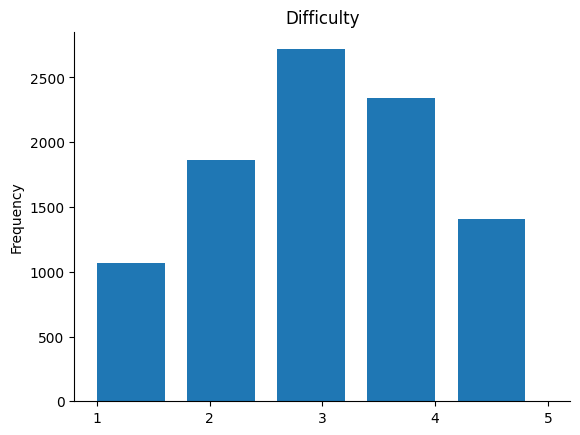

In [8]:
rateMyProfData['Difficulty'].plot(kind='hist', bins=5, title='Difficulty', width=0.6)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xticks(range(1, 6))

plt.show()

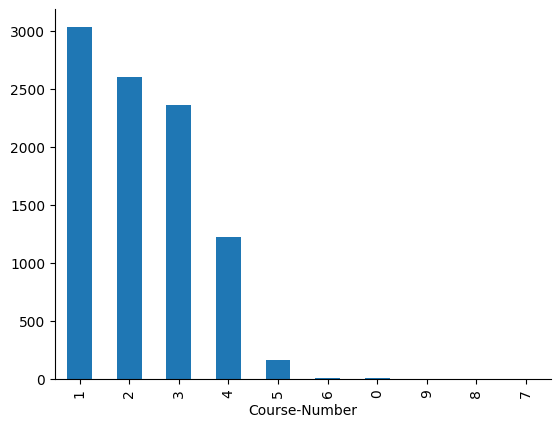

In [9]:
rateMyProfData['Course-Number'].value_counts().plot(kind='bar')
plt.gca().spines[['top', 'right',]].set_visible(False)

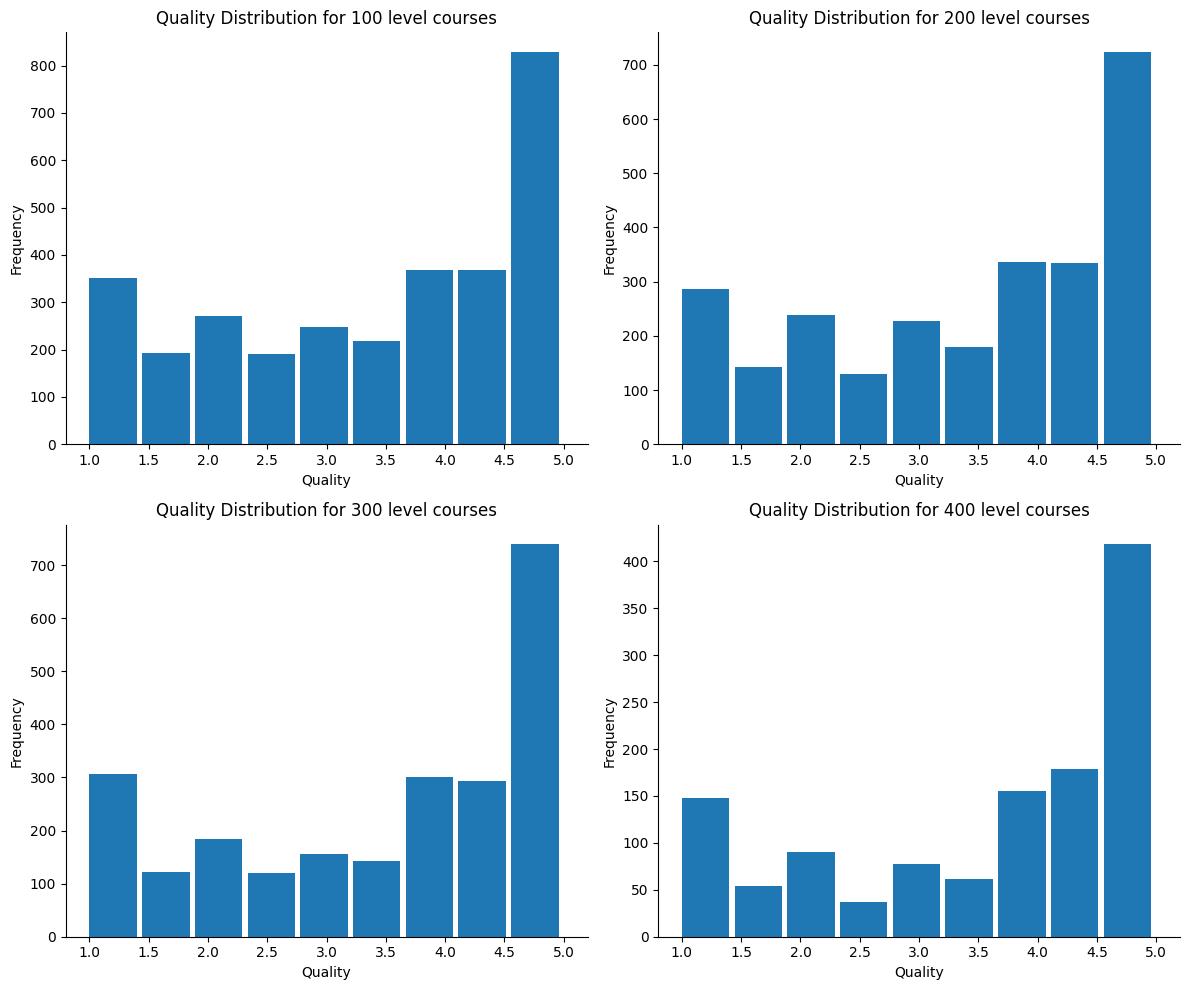

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, course_number in enumerate([1, 2, 3, 4]):
  ax = axes[i // 2, i % 2]
  course_data = rateMyProfData[rateMyProfData['Course-Number'] == str(course_number)]
  course_data['Quality'].plot(kind='hist', bins=9, title=f'Quality Distribution for {course_number}00 level courses', ax=ax, width=0.4)
  ax.spines[['top', 'right']].set_visible(False)
  ax.set_xlabel('Quality')
  ax.set_ylabel('Frequency')

plt.tight_layout()

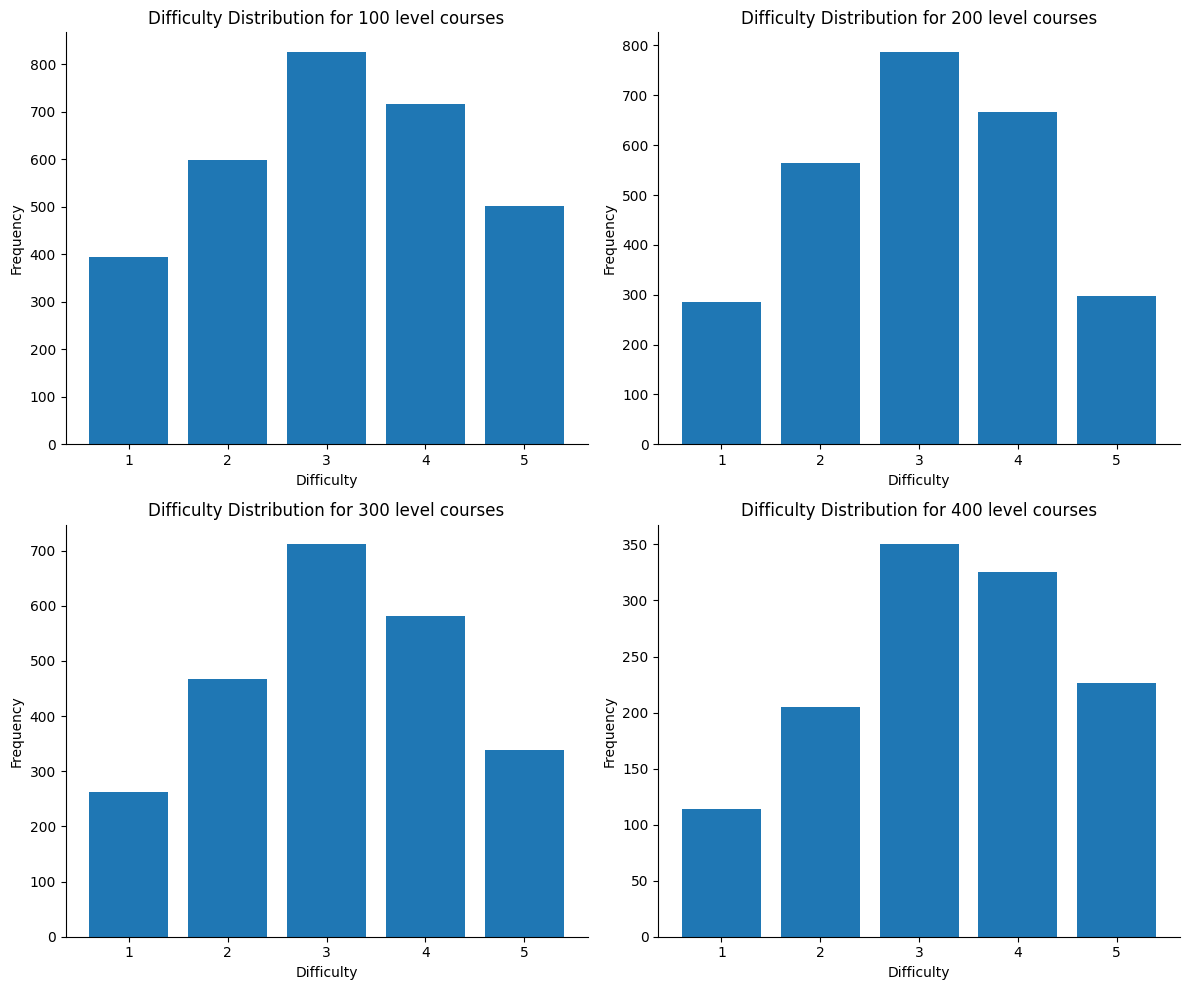

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, course_number in enumerate([1, 2, 3, 4]):
    ax = axes[i // 2, i % 2]
    course_data = rateMyProfData[rateMyProfData['Course-Number'] == str(course_number)]
    difficulty_values = course_data['Difficulty']
    bin_edges = np.arange(0.5, 6, 1)  # Calculate bin edges manually to center bars
    ax.hist(difficulty_values, bins=bin_edges, align='mid', rwidth=0.8)
    ax.set_title(f'Difficulty Distribution for {course_number}00 level courses')
    ax.set_xlabel('Difficulty')
    ax.set_ylabel('Frequency')
    ax.set_xticks(range(1, 6))
    ax.set_xticklabels(range(1, 6))
    ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()

In [12]:
course_counts = rateMyProfData['Course-Name'].value_counts()
for course_name, count in course_counts.items():
  if count > 100:
    print(f"{course_name}: {count}")

CHEM: 602
BBUS: 539
BIS: 461
PSYCH: 428
MATH: 379
PHYS: 379
COM: 354
SOC: 310
ECON: 300
ENGL: 255
GEOG: 239
ACCTG: 199
BCUSP: 176
PHIL: 166
CSS: 146
POLS: 137
ENG: 128
CSE: 123
ESRM: 121
BIOL: 120
ITAL: 113


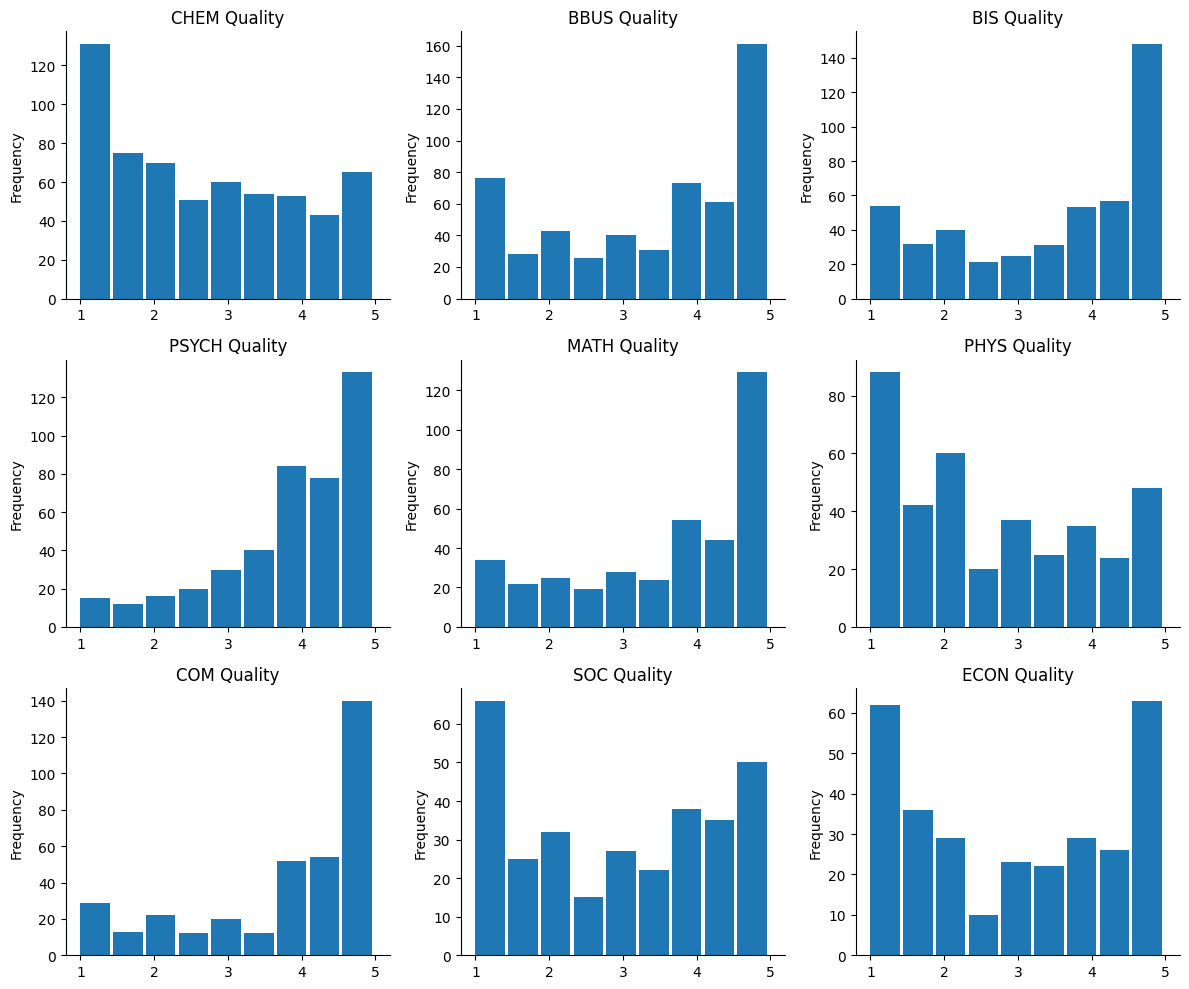

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

for i, course_name in enumerate(course_counts.index[:9]):
  ax = axes[i // 3, i % 3]
  course_data = rateMyProfData[rateMyProfData['Course-Name'] == course_name]
  course_data['Quality'].plot(kind='hist', bins=9, title=f'{course_name} Quality', ax=ax, width=0.4)
  ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()

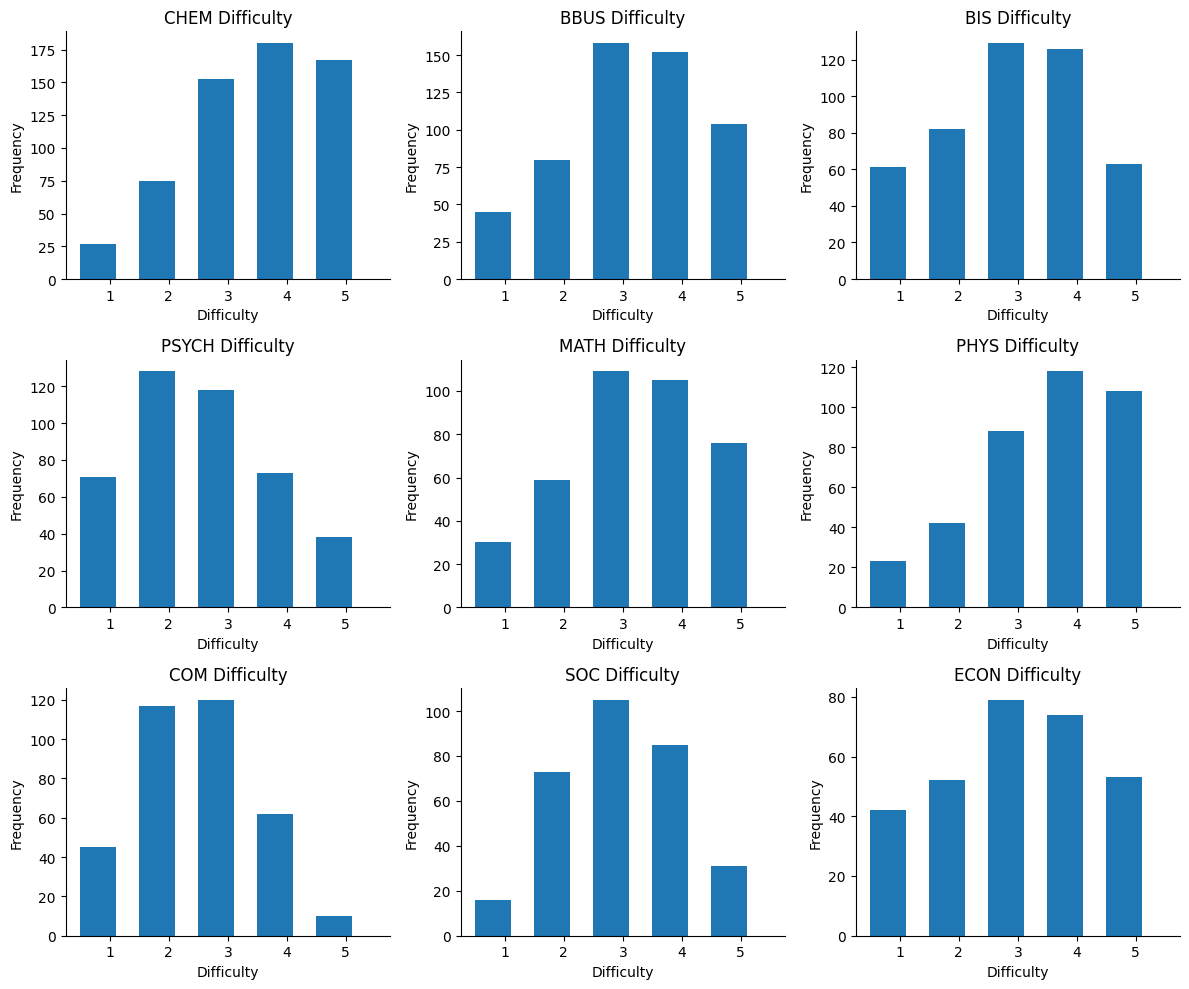

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

for i, course_name in enumerate(course_counts.index[:9]):
  ax = axes[i // 3, i % 3]
  course_data = rateMyProfData[rateMyProfData['Course-Name'] == course_name]
  bin_edges = np.arange(0.5, 6, 1)  # Calculate bin edges manually to center bars
  course_data['Difficulty'].plot(kind='hist', bins=bin_edges, title=f'{course_name} Difficulty', ax=ax, width=0.6)
  ax.spines[['top', 'right']].set_visible(False)
  ax.set_xlabel('Difficulty')
  ax.set_ylabel('Frequency')
  ax.set_xticks(range(1, 6))
  ax.set_xticklabels(range(1, 6))

plt.tight_layout()

Possible analysis with date

# **Prediction of Quality and Difficulty**

## **Basic Machine Learning**

To start creating a prediction of quality and difficulty for the reviews, we need to do some pre-processing on the review bodies. Our goal is to compare a basic Machine Learning model here to a more robust transformer. We have chosen to use a linear regression model, and to compare it to a BERT model.

### Review Pre-Processing for Logistic Regression Model

In [15]:
# Send to lowercase
rateMyProfData['cleanReview'] = rateMyProfData['Review-Body'].str.lower()
# remove numbers
rateMyProfData['cleanReview'] = rateMyProfData['cleanReview'].apply(lambda x: re.sub(r'\d+', '', x)) 
# remove punctuation
rateMyProfData['cleanReview'] = rateMyProfData['cleanReview'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation))) 
# remove extra spaces
rateMyProfData['cleanReview'] = rateMyProfData['cleanReview'].apply(lambda x: ' '.join([token for token in x.split()]))
# remove stop words
stop = set(stopwords.words('english'))
rateMyProfData['cleanReview'] = rateMyProfData['cleanReview'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

rateMyProfData['cleanReview'].head()

0    hard class dont expect isnt clear expected syl...
1    syllabus clear daily homework huge help quarte...
2    bridge coolest prof ive ever joy passion subje...
3    bridge makes abundantly clear need know get go...
4        one best professors ever truly cares students
Name: cleanReview, dtype: object

#### Word Tokenization

In [16]:
rateMyProfData['review_tokens'] = rateMyProfData['cleanReview'].apply(lambda x: word_tokenize(x))
rateMyProfData['review_tokens'].head()

0    [hard, class, dont, expect, isnt, clear, expec...
1    [syllabus, clear, daily, homework, huge, help,...
2    [bridge, coolest, prof, ive, ever, joy, passio...
3    [bridge, makes, abundantly, clear, need, know,...
4    [one, best, professors, ever, truly, cares, st...
Name: review_tokens, dtype: object

#### POS Tagging

In [17]:
rateMyProfData['review_tokens'] = rateMyProfData['review_tokens'].apply(lambda x: nltk.pos_tag(x))
rateMyProfData['review_tokens'].head()

0    [(hard, JJ), (class, NN), (dont, NN), (expect,...
1    [(syllabus, JJ), (clear, JJ), (daily, JJ), (ho...
2    [(bridge, NN), (coolest, JJS), (prof, NN), (iv...
3    [(bridge, NN), (makes, VBZ), (abundantly, RB),...
4    [(one, CD), (best, JJS), (professors, NNS), (e...
Name: review_tokens, dtype: object

#### Lemmatizing

In [18]:
# need this to get correct POS tag for nltk lemmatizer
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [19]:
lemmatizer = WordNetLemmatizer()

rateMyProfData['review_tokens'] = rateMyProfData['review_tokens'].apply(lambda x: [lemmatizer.lemmatize(word, get_wordnet_pos(tag))
                                                                        if get_wordnet_pos(tag)
                                                                        else lemmatizer.lemmatize(word)
                                                                        for word, tag in x])
rateMyProfData['review_tokens'].head()

0    [hard, class, dont, expect, isnt, clear, expec...
1    [syllabus, clear, daily, homework, huge, help,...
2    [bridge, cool, prof, ive, ever, joy, passion, ...
3    [bridge, make, abundantly, clear, need, know, ...
4    [one, best, professor, ever, truly, care, stud...
Name: review_tokens, dtype: object

### Bag of Words

In [20]:
# Change it to a list of strings so BoW can operate correctly
rateMyProfData['cleanReview'] = rateMyProfData['review_tokens'].apply(lambda x: ' '.join(x))
rateMyProfData['cleanReview'].head()

0    hard class dont expect isnt clear expect sylla...
1    syllabus clear daily homework huge help quarte...
2    bridge cool prof ive ever joy passion subject ...
3    bridge make abundantly clear need know get goo...
4           one best professor ever truly care student
Name: cleanReview, dtype: object

### Creating the Linear Regression Models

In [21]:
# Split the data into test and train for both predictions
X_train_Qual, X_test_Qual, y_train_Qual, y_test_Qual = train_test_split(rateMyProfData['cleanReview'], 
                                                                        rateMyProfData['Quality'], 
                                                                        test_size=0.2, 
                                                                        random_state=42)
X_train_Diff, X_test_Diff, y_train_Diff, y_test_Diff = train_test_split(rateMyProfData['cleanReview'], 
                                                                        rateMyProfData['Difficulty'], 
                                                                        test_size=0.2, 
                                                                        random_state=42)

In [22]:
# Get the bodies for analysis later
X_test_Qual_Orig = X_test_Qual
X_test_Diff_Orig = X_test_Diff

In [23]:
vectorizer_Qual = CountVectorizer()
regressor_Qual = LinearRegression()

vectorizer_Diff = CountVectorizer()
regressor_Diff = LinearRegression()

# Convert the text to a bag-of-words representation
X_train_Qual = vectorizer_Qual.fit_transform(X_train_Qual)
X_test_Qual = vectorizer_Qual.transform(X_test_Qual)

regressor_Qual.fit(X_train_Qual, y_train_Qual)
y_pred_Qual = regressor_Qual.predict(X_test_Qual)

X_train_Diff = vectorizer_Diff.fit_transform(X_train_Diff)
X_test_Diff = vectorizer_Diff.transform(X_test_Diff)

regressor_Diff.fit(X_train_Diff, y_train_Diff)
y_pred_Diff = regressor_Diff.predict(X_test_Diff)

### Analyzing the Linear Regression performances

#### Quality Analysis

In [24]:
mse = mean_squared_error(y_test_Qual, y_pred_Qual)
print("Quality Mean Squared Error:", mse)

Quality Mean Squared Error: 46.74801698679862


In [25]:
example_index = 1
specific_instance = X_test_Qual[example_index]
prediction = regressor_Qual.predict(specific_instance)
actual_label = y_test_Qual.iloc[example_index]
print("Cleaned review body at index:", example_index)
print(X_test_Qual_Orig.iloc[example_index])
print("Actual X_test_Qual[2] label:", actual_label)
print("Prediction for X_test_Qual[2]:", prediction)

Cleaned review body at index: 1
interesting lecture movie clip professor passionate subject matter
Actual X_test_Qual[2] label: 3.5
Prediction for X_test_Qual[2]: [4.22332224]


In [26]:
example_index = 4
specific_instance = X_test_Qual[example_index]
prediction = regressor_Qual.predict(specific_instance)
actual_label = y_test_Qual.iloc[example_index]
print("Cleaned review body at index:", example_index)
print(X_test_Qual_Orig.iloc[example_index])
print("Actual X_test_Qual[2] label:", actual_label)
print("Prediction for X_test_Qual[2]:", prediction)

Cleaned review body at index: 4
professor giffard run rome program uw every class nothing best say experience one memorable life knowledge appreciation rome inspire thanks everything
Actual X_test_Qual[2] label: 5.0
Prediction for X_test_Qual[2]: [21.82756451]


As we can see, the performance is quite terrible. For a range of labels from 0.5 - 5.0, a mean squared error of almost 47 is very bad. 

Further the prediction at index 2 above, isnt too far off, but the prediction at index 4 is way out of scope. We can see from the review bodies that the review at index 4 contains very positive words, it is likely that the regressor is seeing a highly positive review and correlating a little too heavily, also not realizing that the max value is 5.

One thing we found upon researching is to clip the prediction to between 0.5 and 5.0 for quality to eliminate over-estimating highly praising reviews. While this does not actually help the Machine Learning model, it does help the usefulness of the prediction, and the mean-squared error. It is much better now at 4.6, but 4.6 is still quite bad for a range of possible values between 0.5 and 5.0.

In [27]:
y_pred_Qual = np.clip(y_pred_Qual, 0.5, 5.0)

qual_mse = mean_squared_error(y_test_Qual, y_pred_Qual)
print("Quality Mean Squared Error after clipping:", qual_mse)
qual_mae = mean_absolute_error(y_test_Qual, y_pred_Qual)
print(f'Quality Mean Absolute Error: {qual_mae}')
qual_r2 = r2_score(y_test_Qual, y_pred_Qual)
print(f'Quality R-squared: {qual_r2}')

Quality Mean Squared Error after clipping: 4.619036544355828
Quality Mean Absolute Error: 1.652594443283421
Quality R-squared: -1.2311590985355236


#### Difficulty Analysis

In [28]:
mse = mean_squared_error(y_test_Diff, y_pred_Diff)
print("Difficulty Mean Squared Error:", mse)

Difficulty Mean Squared Error: 46.047674748179844


In [29]:
example_index = 7
specific_instance = X_test_Diff[example_index]
prediction = regressor_Diff.predict(specific_instance)
actual_label = y_test_Diff.iloc[example_index]
print("Cleaned review body at index:", example_index)
print(X_test_Diff_Orig.iloc[example_index])
print("Actual X_test_Diff[2] label:", actual_label)
print("Prediction for X_test_Diff[2]:", prediction)

Cleaned review body at index: 7
super interest lot fun really great answer confuse philosophical question class structure really well make really enjoy philosophy
Actual X_test_Diff[2] label: 2.0
Prediction for X_test_Diff[2]: [1.71008775]


In [30]:
example_index = 6
specific_instance = X_test_Diff[example_index]
prediction = regressor_Diff.predict(specific_instance)
actual_label = y_test_Diff.iloc[example_index]
print("Cleaned review body at index:", example_index)
print(X_test_Diff_Orig.iloc[example_index])
print("Actual X_test_Diff[2] label:", actual_label)
print("Prediction for X_test_Diff[2]:", prediction)

Cleaned review body at index: 6
dont ask open book test really hard even though may say easy would note allow
Actual X_test_Diff[2] label: 5.0
Prediction for X_test_Diff[2]: [1.51073189]


Just as before with quality, the performance of the difficulty model is very similarly terrible. This model has a mean-squared error of about 46, which is slightly better. 

The prediction at index 7 above is pretty close, even though the word confuse is in the review, which we thought would increase the difficulty prediction. 

At index 6 also above is even more interesting, even though the review conatains negative phrasing such as dont ask, and contains the word hard, the model predictied a difficulty score of 1.5 relating to very easy, while the true label was 5 out of 5 difficulty. In this review, it is likely because the context of the word easy. In the review to a human reader it seems that the intent of the word easy here is the author contradicting what others have said, and disagreeing with it.

Clipping the prediction to between 1 and 5 for quality to eliminate out of bounds reviews helped here again. Similarly, it does not help the prediction model, but just the output and mean-squared error. It is much better now at 3.7, but again 3.7 is still quite bad for a range of possible values between 1 and 5.

In [31]:
y_pred_Diff = np.clip(y_pred_Diff, 1, 5)

diff_mse = mean_squared_error(y_test_Diff, y_pred_Diff)
print("Difficulty Mean Squared Error after clipping:", diff_mse)
diff_mae = mean_absolute_error(y_test_Diff, y_pred_Diff)
print("Difficulty Mean Absolute Error:", diff_mae)
diff_r2 = r2_score(y_test_Diff, y_pred_Diff)
print("Difficulty R-squared:", diff_r2)

Difficulty Mean Squared Error after clipping: 3.708865813038453
Difficulty Mean Absolute Error: 1.5738076181872556
Difficulty R-squared: -1.5025228953684326


## **BERT NLP Model**

### Pre-Processing for BERT Model

For out BERT model, we decided to use the bert-base-uncased because we should not have any need for a cased version, as there are very few NER cases in the review texts. For this context, the base BERT should be enough without further training as the review body is normal language, and we are not trying to do anything out of the ordinary to it.

In [32]:
review_texts = rateMyProfData['Review-Body'].tolist()

In [33]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Use the BERT uncased transformer to get the reviews into a tokenized uniform format for the model to make predictions on

inputs = tokenizer(review_texts, padding=True, truncation=True, return_tensors="pt")
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
Quality_labels = torch.tensor(rateMyProfData['Quality'].tolist(), dtype=torch.float)
Difficulty_labels = torch.tensor(rateMyProfData['Difficulty'].tolist(), dtype=torch.float)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [34]:
# Split the data for two predictions

train_ids_Qual, test_ids_Qual, train_mask_Qual, test_mask_Qual, train_labels_Qual, test_labels_Qual = train_test_split(
    input_ids, attention_mask, Quality_labels, test_size=0.2, random_state=42
)

train_ids_Diff, test_ids_Diff, train_mask_Diff, test_mask_Diff, train_labels_Diff, test_labels_Diff = train_test_split(
    input_ids, attention_mask, Difficulty_labels, test_size=0.2, random_state=42
)

In [35]:
# Create a class to more easily use functions to access data later.
class ReviewDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }


In [36]:
batch_size = 12

# Create Quality datasets
Qual_train_dataset = ReviewDataset(train_ids_Qual, train_mask_Qual, train_labels_Qual)
Qual_test_dataset = ReviewDataset(test_ids_Qual, test_mask_Qual, test_labels_Qual)

# Create Quality dataloaders
Qual_train_loader = DataLoader(Qual_train_dataset, batch_size=batch_size, shuffle=True)
Qual_test_loader = DataLoader(Qual_test_dataset, batch_size=batch_size, shuffle=False)

# Create Difficulty datasets
Diff_train_dataset = ReviewDataset(train_ids_Diff, train_mask_Diff, train_labels_Diff)
Diff_test_dataset = ReviewDataset(test_ids_Diff, test_mask_Diff, test_labels_Diff)

# Create Difficulty dataloaders
Diff_train_loader = DataLoader(Diff_train_dataset, batch_size=batch_size, shuffle=True)
Diff_test_loader = DataLoader(Diff_test_dataset, batch_size=batch_size, shuffle=False)

In [37]:
print(len(Diff_train_dataset))
print(len(Diff_train_loader))

7517
627


### Create and Train the Model

In [38]:
class BertForRegression(nn.Module):
    def __init__(self, model_name='bert-base-uncased'):
        super(BertForRegression, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.regressor = nn.Linear(self.bert.config.hidden_size, 1)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        reg_output = self.regressor(cls_output)
        return reg_output

# Instantiate the models
Qual_model = BertForRegression()
Diff_model = BertForRegression()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()


In [39]:
if not os.path.isfile('qual_model.pth'):
    torch.cuda.empty_cache()

    # Define loss function and optimizer
    Qual_optimizer = optim.Adam(Qual_model.parameters(), lr=1e-5)

    # Train the model
    Qual_model.to(device)

    Qual_model.train()
    for epoch in range(3):  # Number of epochs
        for batch_idx, batch in enumerate(Qual_train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).unsqueeze(1)
            
            Qual_optimizer.zero_grad()
            outputs = Qual_model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            Qual_optimizer.step()
            
            print(f"Epoch {epoch}, Batch Status: {batch_idx}/{len(Qual_train_loader)}, Loss: {loss.item()}")
            if batch_idx % 10 == 0:
                torch.cuda.empty_cache()
    torch.save(Qual_model.state_dict(), 'qual_model.pth')

In [40]:
if not os.path.isfile('diff_model.pth'):
    torch.cuda.empty_cache()

    # Define optimizer
    Diff_optimizer = optim.Adam(Diff_model.parameters(), lr=1e-5)

    # Train the model
    Diff_model.to(device)

    Diff_model.train()
    for epoch in range(3):  # Number of epochs
        for batch_idx, batch in enumerate(Diff_train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).unsqueeze(1)
            
            Diff_optimizer.zero_grad()
            outputs = Diff_model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            Diff_optimizer.step()
            
            print(f"Epoch {epoch}, Batch Status: {batch_idx}/{len(Diff_train_loader)}, Loss: {loss.item()}")
            if batch_idx % 10 == 0:
                torch.cuda.empty_cache()
    torch.save(Diff_model.state_dict(), 'diff_model.pth')

In [41]:
torch.cuda.empty_cache()
qual_model = BertForRegression()
qual_model.load_state_dict(torch.load('qual_model.pth', map_location=torch.device('cpu')))
qual_model.eval()
qual_model = qual_model.to(device)
test_loss = 0

qual_all_labels = []
qual_all_predictions = []

with torch.no_grad():
    for batch_idx, batch in enumerate(Qual_test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).unsqueeze(1)
        
        outputs = qual_model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predictions = outputs.detach().cpu().numpy()
        true_labels = labels.detach().cpu().numpy()
        
        qual_all_predictions.extend(predictions)
        qual_all_labels.extend(true_labels)

    qual_avg_test_loss = test_loss / len(Qual_test_loader)
    print(f"Quality Test Loss: {qual_avg_test_loss}")
    if batch_idx % 10 == 0:
        torch.cuda.empty_cache()

Quality Test Loss: 0.6186218950304256


In [42]:
diff_model = BertForRegression()
diff_model.load_state_dict(torch.load('diff_model.pth', map_location=torch.device('cpu')))
diff_model.eval()
diff_model = diff_model.to(device)
test_loss = 0

diff_all_labels = []
diff_all_predictions = []

with torch.no_grad():
    for batch_idx, batch in enumerate(Diff_test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).unsqueeze(1)
        
        outputs = diff_model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predictions = outputs.detach().cpu().numpy()
        true_labels = labels.detach().cpu().numpy()
        
        diff_all_predictions.extend(predictions)
        diff_all_labels.extend(true_labels)

    diff_avg_test_loss = test_loss / len(Diff_test_loader)
    print(f"Difficulty Test Loss: {diff_avg_test_loss}")
    if batch_idx % 10 == 0:
        torch.cuda.empty_cache()

Difficulty Test Loss: 1.0040646021722988


In [43]:
BERT_qual_mae = mean_absolute_error(qual_all_labels, qual_all_predictions)
print(f"Mean Absolute Error: {BERT_qual_mae}")

Mean Absolute Error: 0.5664135813713074


In [44]:
BERT_diff_mae = mean_absolute_error(diff_all_labels, diff_all_predictions)
print(f"Mean Absolute Error: {BERT_diff_mae}")

Mean Absolute Error: 0.8068426847457886


In [45]:
BERT_qual_r2 = r2_score(qual_all_labels, qual_all_predictions)
print(f"R-squared: {BERT_qual_r2}")

R-squared: 0.7010633043886598


In [46]:
BERT_diff_r2 = r2_score(diff_all_labels, diff_all_predictions)
print(f"R-squared: {BERT_diff_r2}")

R-squared: 0.32127247476660814


From the above, we have trained a BERT regression model to predict both quality and difficulty based on the same dataset as the linear regression model. The test loss for quality and difficulty respectively is .62 and 1.00. these values are not perfect, but actually quite good and within the scopes of 0.5-5.0 and 1-5. They are performing well predicting the quality and difficulty scores based only on the review text.

## **Comparing the Two Models**

Because we defined the criterion as "criterion = nn.MSELoss()" the comparison between the performance of the two models is straightforward, as the scores are both calculated using mean-squared error.

In [47]:
print(f"BERT model Difficulty Test Loss: {diff_avg_test_loss}")
print(f"BERT model Quality Test Loss: {qual_avg_test_loss}")

BERT model Difficulty Test Loss: 1.0040646021722988
BERT model Quality Test Loss: 0.6186218950304256


In [48]:
print(f"Linear regression model Difficulty Test MSE: {diff_mse}")
print(f"Linear regression model Quality Test MSE: {qual_mse}")

Linear regression model Difficulty Test MSE: 3.708865813038453
Linear regression model Quality Test MSE: 4.619036544355828


The BERT model performed significantly better in both predictions, especially before adding the clipping to the initial regression model.

In [55]:
print(f"Linear regression model Difficulty Test MSE: {diff_mse}")
print(f"Linear regression model Quality Test MSE: {qual_mse}")
print(f"BERT model Difficulty Test Loss: {diff_avg_test_loss}")
print(f"BERT model Quality Test Loss: {qual_avg_test_loss}")
improvement_percentage = ((diff_mse - diff_avg_test_loss) / diff_mse) * 100
print(f"BERT model performed {improvement_percentage:.2f}% better in difficulty predictions")

improvement_percentage = ((qual_mse - qual_avg_test_loss) / qual_mse) * 100
print(f"BERT model performed {improvement_percentage:.2f}% better in quality predictions")


Linear regression model Difficulty Test MSE: 3.708865813038453
Linear regression model Quality Test MSE: 4.619036544355828
BERT model Difficulty Test Loss: 1.0040646021722988
BERT model Quality Test Loss: 0.6186218950304256
BERT model performed 72.93% better in difficulty predictions
BERT model performed 86.61% better in quality predictions


In [50]:
print("Linear regression model Difficulty Mean Absolute Error:", diff_mae)
print(f'Linear regression model Quality Mean Absolute Error: {qual_mae}')
print(f"BERT Quality Mean Absolute Error: {BERT_qual_mae}")
print(f"BERT Difficulty Mean Absolute Error: {BERT_diff_mae}")
print(" ")
improvement_percentage = ((diff_mae - BERT_diff_mae) / diff_mae) * 100
print(f"BERT model performed {improvement_percentage:.2f}% better in difficulty predictions")

improvement_percentage = ((qual_mae - BERT_qual_mae) / qual_mae) * 100
print(f"BERT model performed {improvement_percentage:.2f}% better in quality predictions")

Linear regression model Difficulty Mean Absolute Error: 1.5738076181872556
Linear regression model Quality Mean Absolute Error: 1.652594443283421
BERT Quality Mean Absolute Error: 0.5664135813713074
BERT Difficulty Mean Absolute Error: 0.8068426847457886
 
BERT model performed 48.73% better in difficulty predictions
BERT model performed 65.73% better in quality predictions


In [51]:
print("Linear regression model Difficulty R-squared:", diff_r2)
print(f'Linear regression model Quality R-squared: {qual_r2}')
print(f"BERT Quality R-squared: {BERT_qual_r2}")
print(f"BERT Difficulty R-squared: {BERT_diff_r2}")
print(" ")
improvement_percentage = ((diff_r2 - BERT_diff_r2) / diff_r2) * 100
print(f"BERT model performed {improvement_percentage:.2f}% better in difficulty predictions")

improvement_percentage = ((qual_r2 - BERT_qual_r2) / qual_r2) * 100
print(f"BERT model performed {improvement_percentage:.2f}% better in quality predictions")

Linear regression model Difficulty R-squared: -1.5025228953684326
Linear regression model Quality R-squared: -1.2311590985355236
BERT Quality R-squared: 0.7010633043886598
BERT Difficulty R-squared: 0.32127247476660814
 
BERT model performed 121.38% better in difficulty predictions
BERT model performed 156.94% better in quality predictions


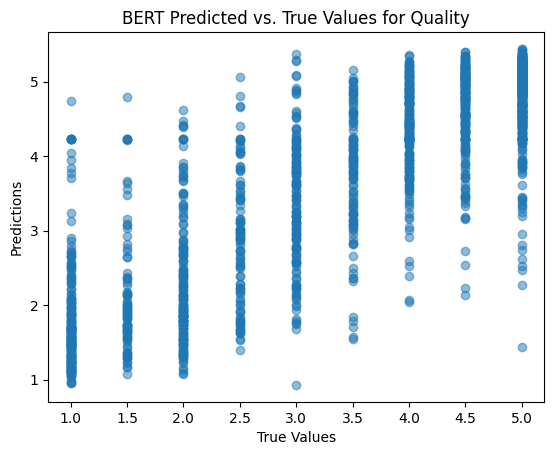

In [52]:
plt.scatter(qual_all_labels, qual_all_predictions, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('BERT Predicted vs. True Values for Quality')
plt.show()

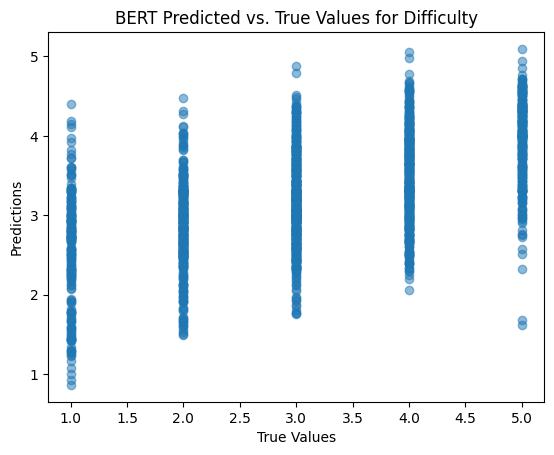

In [53]:
plt.scatter(diff_all_labels, diff_all_predictions, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('BERT Predicted vs. True Values for Difficulty')
plt.show()

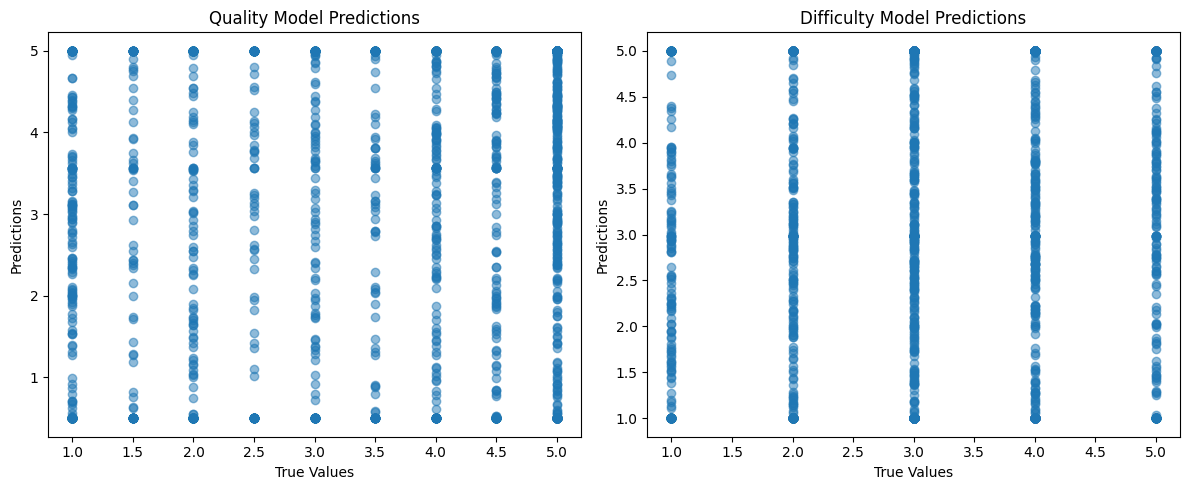

In [54]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_Qual, y_pred_Qual, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Quality Model Predictions')

# Plot predictions vs true values for difficulty model
plt.subplot(1, 2, 2)
plt.scatter(y_test_Diff, y_pred_Diff, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Difficulty Model Predictions')

plt.tight_layout()
plt.show()

These results are not surprising at all, as the BERT model is much more robust than bag of words and traditional linear regression models.

# Toxicity Model Predictions
Here, we analyze our dataset for toxic reviews. We'll use three approaches: a classical ML approach using Naive Bayes, a standard transformer approach using RoBERTa, and an experimental transformer approach using ELECTRA for seeing if Replaced Token Detection might help with detecting toxicity. 

ML Portion: Find Toxicity Using Naive Bayes 

In [46]:
# Naive Bayes predictions are already done and processed external to this notbook. The results and respective notebook can be found in the toxicity models folder. 

Roberta Toxicity Predictions

In [47]:
!pip install openpyxl

import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
import torch
import random

# Set a fixed state for randomness
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)  # If using CUDA

# Load the tokenizer and model for inference
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('toxicity_models/RoBERTa Model and code/fine_tuned_roberta')

# Move the model to CPU if it's on CUDA device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Put the model in evaluation mode
model.eval()

# Function to convert LABEL_0 to 'no'
def convert_label(prediction):
    return 'no' if prediction[0]['label'] == 'LABEL_0' else 'yes'


global count
global sub_mention
sub_mention = False
profanity_in = False
count = 0

def predict_label(row):
    global count
    global sub_mention
    text_to_predict = row['Review-Body']
    if pd.isnull(text_to_predict):
      text_to_predict = "No Comments" 
    encoding = tokenizer(text_to_predict, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits).cpu().numpy().flatten()
    binary_label = 1 if np.abs(probabilities[0]) > 0.538298547 else 0
    count = count + 1
    if (count % 1000 == 0):
      print(count)
    if(count < 25):
      # Print out some examples of stream comments and their respective probabilities and label (toxic/non-toxic)
      print(text_to_predict)
      print(np.abs(probabilities[0]))
      print(binary_label)


    return binary_label, probabilities[0]
    
twitch_df = pd.read_csv('Cleaned_UW_RMP.csv')
print(f"Total length of test: {len(twitch_df)}")

# Apply the prediction function to each row in the DataFrame
roberta_predictions_df = twitch_df.apply(predict_label, axis=1, result_type='expand')

Total length of test: 10002
It's not hard class, but don't expect the 4.0. She isn't clear about what is expected and the syllabus changed multiple times over the quarter. You can tell she doesn't take business students seriously and makes you feel awkward about your responses which really discourages participation.
0.5382911
0
Syllabus was clear on what the daily homework was, which was a huge help for the quarter! Would recommend uploading her powerpoint presentations before her class to stay keep up with lectures; what she says verbally shows up on the midterms! Also reading the textbook helped!! Overall, good professor but her lectures are a bore.
0.538291
0
Bridge is the coolest prof I've ever had. His joy and passion of the subjects he teaches is next level. He's always telling stories that relate to the subject in interesting ways. Easy grader and really cares that the students fully understand, and succeed in his course. Clear and fair expectations, do the homeworks and you'll 

Electra Toxicity Predictions

In [48]:
!pip install openpyxl
import pandas as pd
import numpy as np
from transformers import ElectraTokenizer, AutoModelForSequenceClassification
import torch
import random

# Set a fixed state for randomness
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)  # If using CUDA

# Load the tokenizer and model for inference
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
model = AutoModelForSequenceClassification.from_pretrained('toxicity_models/ELECTRA Model and Code/fine_tuned_electra')

# Move the model to CPU if it's on CUDA device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Put the model in evaluation mode
model.eval()

# Function to convert LABEL_0 to 'no'
def convert_label(prediction):
    return 'no' if prediction[0]['label'] == 'LABEL_0' else 'yes'

global count
global sub_mention
sub_mention = False
profanity_in = False
count = 0

def predict_label(row):
    global count
    global sub_mention
    text_to_predict = row['Review-Body']
    if pd.isnull(text_to_predict):
      text_to_predict = "No Comments" 
    # Leverages better profanity to catch additional profanity occurences
    encoding = tokenizer(text_to_predict, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits).cpu().numpy().flatten()
    binary_label = 1 if np.abs(probabilities[0]) > 0.56 else 0
    count = count + 1
    if (count % 1000 == 0):
      print(count)
    if(count < 25):
      # Print out some examples of stream comments and their respective probabilities and label (toxic/non-toxic)
      print(text_to_predict)
      print(np.abs(probabilities[0]))
      print(binary_label)

    return binary_label, probabilities[0]
    
twitch_df = pd.read_csv('Cleaned_UW_RMP.csv')
print(f"Total length of test: {len(twitch_df)}")

# Apply the prediction function to each row in the DataFrame
electra_predictions_df = twitch_df.apply(predict_label, axis=1, result_type='expand')


Total length of test: 10002
It's not hard class, but don't expect the 4.0. She isn't clear about what is expected and the syllabus changed multiple times over the quarter. You can tell she doesn't take business students seriously and makes you feel awkward about your responses which really discourages participation.
0.49894
0
Syllabus was clear on what the daily homework was, which was a huge help for the quarter! Would recommend uploading her powerpoint presentations before her class to stay keep up with lectures; what she says verbally shows up on the midterms! Also reading the textbook helped!! Overall, good professor but her lectures are a bore.
0.5023043
0
Bridge is the coolest prof I've ever had. His joy and passion of the subjects he teaches is next level. He's always telling stories that relate to the subject in interesting ways. Easy grader and really cares that the students fully understand, and succeed in his course. Clear and fair expectations, do the homeworks and you'll e

 Skolkovo Institute Trained Roberta Model for Possible Toxicity Baseline

Our RoBERTa model backfired and only gave 1 toxic comment flag. Added the Skolkovo Institute's RoBERTa model for a baseline to ensure that RoBERTa isn't the problem, but perhaps, our dataset.  

 NOTE: Skolkovo's model checks for non-toxicity. The higher the value, the more neutral it is. In our case, most toxic elements started appearing beneath the .97 value, so this threshold checks for every probability less than .97. This kind of threshold magnitude is likely a side-effect of having trained our student reviews containing only a little amount of extremely toxic elements both our models and the Skolkovo model were trained on (and probably expecting). 

In [49]:
!pip install openpyxl
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
import torch
import random

# Set a fixed state for randomness
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)  # If using CUDA

# Load the tokenizer and model for inference
tokenizer = RobertaTokenizer.from_pretrained('SkolkovoInstitute/roberta_toxicity_classifier')
model = AutoModelForSequenceClassification.from_pretrained('SkolkovoInstitute/roberta_toxicity_classifier')

# Move the model to CPU if it's on CUDA device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Put the model in evaluation mode
model.eval()

# Function to convert LABEL_0 to 'no'
def convert_label(prediction):
    return 'no' if prediction[0]['label'] == 'LABEL_0' else 'yes'

global count
global sub_mention
sub_mention = False
profanity_in = False
count = 0

def predict_label(row):
    global count
    global sub_mention
    text_to_predict = row['Review-Body']
    if pd.isnull(text_to_predict):
      text_to_predict = "No Comments" 
    # Leverages better profanity to catch additional profanity occurences
    encoding = tokenizer(text_to_predict, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits).cpu().numpy().flatten()
    binary_label = 1 if np.abs(probabilities[0]) < 0.979305923 else 0
    count = count + 1
    if (count % 1000 == 0):
      print(count)
    if(count < 25):
      # Print out some examples of stream comments and their respective probabilities and label (toxic/non-toxic)
      print(text_to_predict)
      print(np.abs(probabilities[0]))
      print(binary_label)

    return binary_label, probabilities[0]
    
twitch_df = pd.read_csv('Cleaned_UW_RMP.csv')
print(f"Total length of test: {len(twitch_df)}")

# Apply the prediction function to each row in the DataFrame
altRoberta_predictions_df = twitch_df.apply(predict_label, axis=1, result_type='expand')


c:\Users\adity\anaconda3\envs\myenv\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to 

Total length of test: 10002
It's not hard class, but don't expect the 4.0. She isn't clear about what is expected and the syllabus changed multiple times over the quarter. You can tell she doesn't take business students seriously and makes you feel awkward about your responses which really discourages participation.
0.9934964
0
Syllabus was clear on what the daily homework was, which was a huge help for the quarter! Would recommend uploading her powerpoint presentations before her class to stay keep up with lectures; what she says verbally shows up on the midterms! Also reading the textbook helped!! Overall, good professor but her lectures are a bore.
0.99122685
0
Bridge is the coolest prof I've ever had. His joy and passion of the subjects he teaches is next level. He's always telling stories that relate to the subject in interesting ways. Easy grader and really cares that the students fully understand, and succeed in his course. Clear and fair expectations, do the homeworks and you'l

In [50]:
#Export the predictions to a CSV file
toxRating_df = pd.DataFrame()
toxRating_df['Review_Body'] = twitch_df['Review-Body']

nb_df = pd.read_csv("toxicity_models/Naive Bayes Model and Code/naivebayes_UWBR_predictions.csv")

toxRating_df['NaiveBayes_UWBR_predictions'],toxRating_df['NaiveBayes_UWBR_probabilities'] = nb_df['NaiveBayes_UWBR_predictions'], nb_df['NaiveBayes_UWBR_probabilities']
toxRating_df['roberta_UWBR_predictions'],toxRating_df['roberta_UWBR_probabilities'] = roberta_predictions_df[0], roberta_predictions_df[1]
toxRating_df['electra_UWBR_predictions'],toxRating_df['electra_UWBR_probabilities'] = electra_predictions_df[0], electra_predictions_df[1]
toxRating_df['skolkovo_UWBR_predictions'],toxRating_df['skolkovo_UWBR_probabilities'] = altRoberta_predictions_df[0], altRoberta_predictions_df[1]
toxRating_df.to_csv("Cleaned_UW_RMP_ToxRatingsV1.csv", index = False)

# **Sentiment Analysis**

In [ ]:
%pip install datasets transformers

In [56]:
import pandas as pd
import numpy as np
from transformers import pipeline

In [58]:

cmv_df = pd.read_csv('Cleaned_UW_RMP.csv')
# Max emotions represents the total emotions generated for each comment (ie our max)
# Min emotions represents the minimum number of emotions we accept for each comment (threshold)
max_emotions = 6
min_emotions = 3
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=max_emotions)

test_comment_1 = cmv_df.iloc[0]['Review-Body']


sentences = [test_comment_1]

print("Initial 3 labels")
for sentence in sentences:
  output = classifier(sentence)
  print(output)

print("")
print("Filtered 3 labels")

# Builds a list of labels to filter out
labels_to_exclude = ['neutral', 'approval']

for sentence in sentences:
    output = classifier(sentence)
    filtered_labels = []
    num_labels = 0

    # Check predictions and filter out labels that are found in the labels_to_exclude
    for prediction in output:
        filtered_predictions = [label for label in prediction if label['label'] not in labels_to_exclude]
        # Check to see if we still need to add more emotions to reach the minimum threshold for classification
        if (num_labels < min_emotions):
          # If we have not reached the min threshold, keep adding emotions
          filtered_labels.append(filtered_predictions)
          num_labels += 1

    print(filtered_labels)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Initial 3 labels
[[{'label': 'neutral', 'score': 0.36547425389289856}, {'label': 'disapproval', 'score': 0.31943556666374207}, {'label': 'disappointment', 'score': 0.23140522837638855}, {'label': 'annoyance', 'score': 0.21146142482757568}, {'label': 'embarrassment', 'score': 0.06383761763572693}, {'label': 'realization', 'score': 0.03129347413778305}]]

Filtered 3 labels
[[{'label': 'disapproval', 'score': 0.31943556666374207}, {'label': 'disappointment', 'score': 0.23140522837638855}, {'label': 'annoyance', 'score': 0.21146142482757568}, {'label': 'embarrassment', 'score': 0.06383761763572693}, {'label': 'realization', 'score': 0.03129347413778305}]]


In [61]:

import pandas as pd
from transformers import pipeline
from datasets import Dataset
from concurrent.futures import ThreadPoolExecutor, as_completed

# Load dataset into a Pandas DataFrame
cmv_df = pd.read_csv('Cleaned_UW_RMP.csv')

# Initialize the text classification pipeline with GPU support
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=5, device=0)

# Initialize a dictionary to store emotion frequencies
emotion_frequency = {}

# Function to process a batch of texts
def process_batch(batch_comments):
    outputs = classifier(batch_comments)
    local_emotion_frequency = {}
    for output in outputs:
        emotion_labels = [label['label'] for label in output]
        for emotion_label in emotion_labels:
            if emotion_label not in local_emotion_frequency:
                local_emotion_frequency[emotion_label] = 1
            else:
                local_emotion_frequency[emotion_label] += 1
    return local_emotion_frequency

# Batch processing with parallel execution
batch_size = 32  # Adjust the batch size according to your memory capacity
comments = cmv_df['Review-Body'].dropna().tolist()
batches = [comments[i:i + batch_size] for i in range(0, len(comments), batch_size)]

with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust number of workers based on your environment
    futures = {executor.submit(process_batch, batch): batch for batch in batches}
    for future in as_completed(futures):
        batch_emotion_frequency = future.result()
        for emotion, count in batch_emotion_frequency.items():
            if emotion not in emotion_frequency:
                emotion_frequency[emotion] = count
            else:
                emotion_frequency[emotion] += count

# Print the final resulting emotion frequencies
print("Final Emotion Frequencies:")
for emotion, count in emotion_frequency.items():
    print(f"{emotion}: {count}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Final Emotion Frequencies:
admiration: 6837
approval: 8002
optimism: 2621
neutral: 8341
excitement: 817
love: 1011
gratitude: 989
joy: 2221
desire: 259
amusement: 1419
caring: 1382
disapproval: 4000
annoyance: 3704
disappointment: 2650
realization: 2622
confusion: 623
curiosity: 246
anger: 883
relief: 117
pride: 72
disgust: 541
nervousness: 25
fear: 161
sadness: 281
embarrassment: 33
remorse: 42
surprise: 99
grief: 7


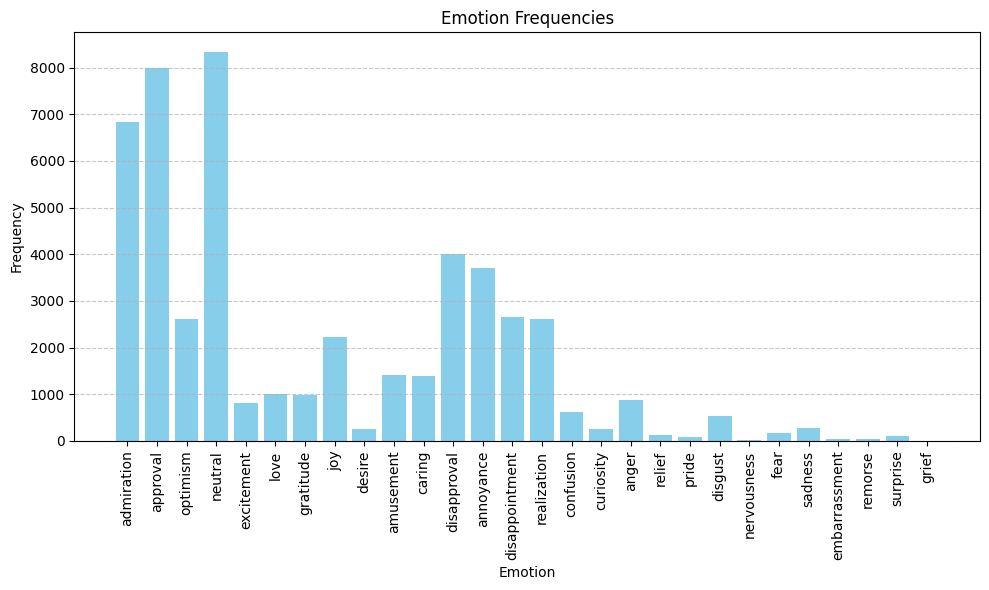

In [62]:
import matplotlib.pyplot as plt

# Extract emotion labels and corresponding frequencies from our final list
emotions = list(emotion_frequency.keys())
frequencies = list(emotion_frequency.values())

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(emotions, frequencies, color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.title('Emotion Frequencies')
# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Adjust layout to prevent label clips
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ANOVA Table for admiration based on Difficulty:
                    sum_sq      df          F        PR(>F)
C(Difficulty)    64.440050     4.0  116.83503  1.478809e-97
Residual       1378.316791  9996.0        NaN           NaN

Regression Summary for admiration based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:             admiration   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     116.8
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           1.48e-97
Time:                        00:02:37   Log-Likelihood:                -4280.7
No. Observations:               10001   AIC:                             8571.
Df Residuals:                    9996   BIC:                             8607.
Df Model:                           4                                         
Covar

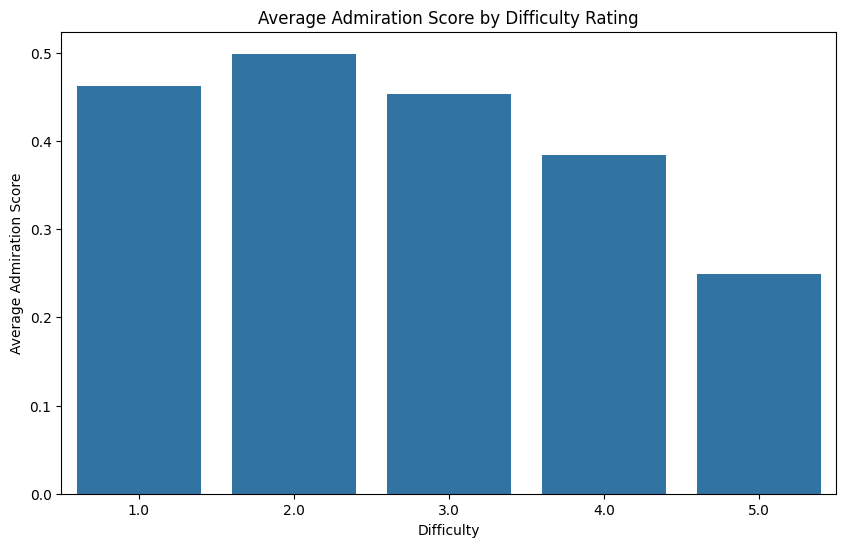

ANOVA Table for admiration based on Quality:
                 sum_sq      df           F  PR(>F)
C(Quality)   355.878786     8.0  408.962719     0.0
Residual    1086.878054  9992.0         NaN     NaN

Regression Summary for admiration based on Quality:
                            OLS Regression Results                            
Dep. Variable:             admiration   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     409.0
Date:                Mon, 03 Jun 2024   Prob (F-statistic):               0.00
Time:                        00:02:37   Log-Likelihood:                -3092.8
No. Observations:               10001   AIC:                             6204.
Df Residuals:                    9992   BIC:                             6269.
Df Model:                           8                                         
Covariance Type:            nonrobu

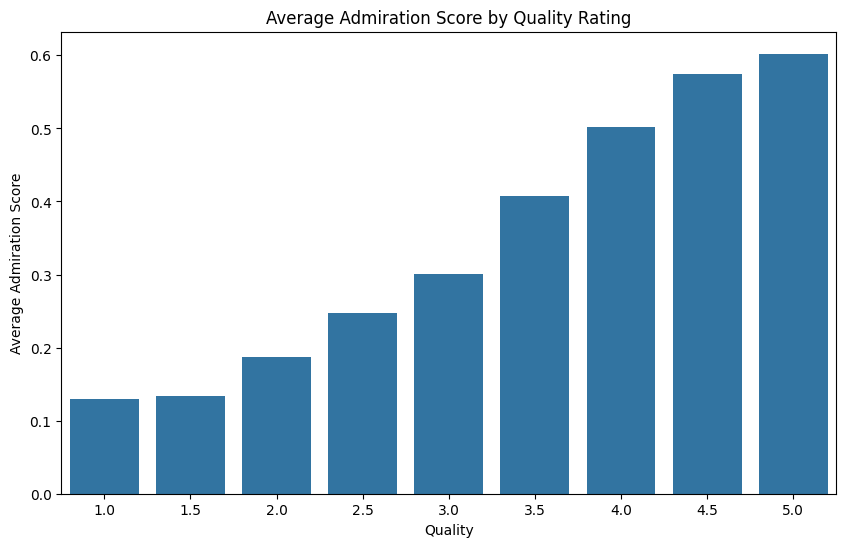

ANOVA Table for approval based on Difficulty:
                   sum_sq      df          F        PR(>F)
C(Difficulty)    3.481793     4.0  47.098018  2.770132e-39
Residual       184.742382  9996.0        NaN           NaN

Regression Summary for approval based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:               approval   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     47.10
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           2.77e-39
Time:                        00:02:37   Log-Likelihood:                 5768.6
No. Observations:               10001   AIC:                        -1.153e+04
Df Residuals:                    9996   BIC:                        -1.149e+04
Df Model:                           4                                         
Covariance T

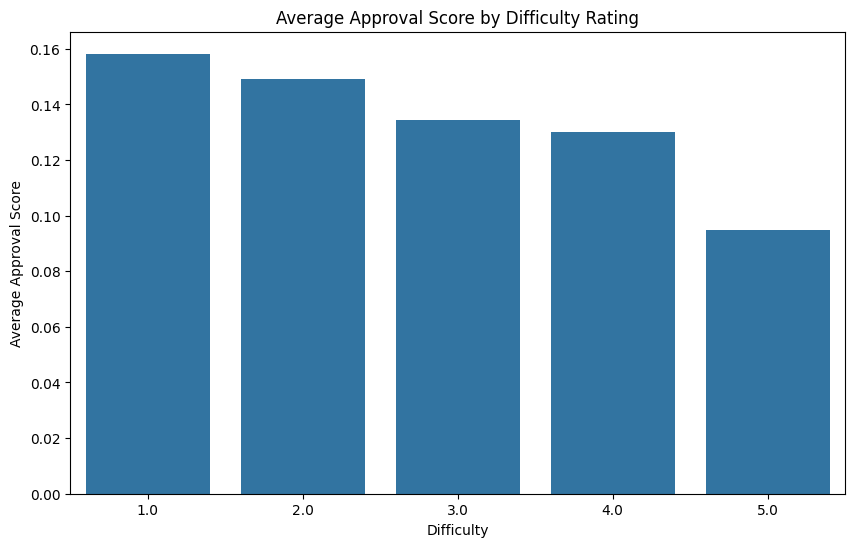

ANOVA Table for approval based on Quality:
                sum_sq      df           F         PR(>F)
C(Quality)   14.345802     8.0  103.048505  9.038552e-166
Residual    173.878373  9992.0         NaN            NaN

Regression Summary for approval based on Quality:
                            OLS Regression Results                            
Dep. Variable:               approval   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     103.0
Date:                Mon, 03 Jun 2024   Prob (F-statistic):          9.04e-166
Time:                        00:02:37   Log-Likelihood:                 6071.6
No. Observations:               10001   AIC:                        -1.213e+04
Df Residuals:                    9992   BIC:                        -1.206e+04
Df Model:                           8                                         
Covariance Type:     

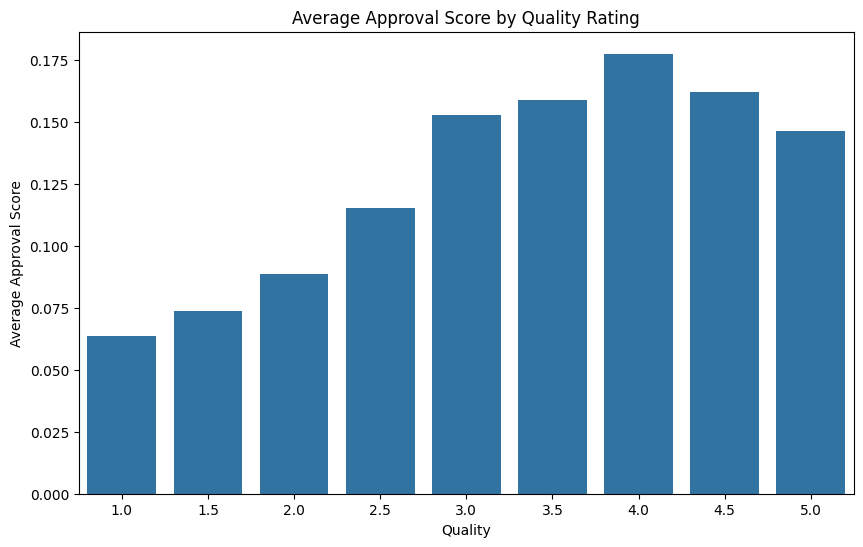

ANOVA Table for optimism based on Difficulty:
                  sum_sq      df         F    PR(>F)
C(Difficulty)   0.025058     4.0  1.867125  0.113198
Residual       33.538707  9996.0       NaN       NaN

Regression Summary for optimism based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:               optimism   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.867
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.113
Time:                        00:02:38   Log-Likelihood:                 14301.
No. Observations:               10001   AIC:                        -2.859e+04
Df Residuals:                    9996   BIC:                        -2.856e+04
Df Model:                           4                                         
Covariance Type:            no

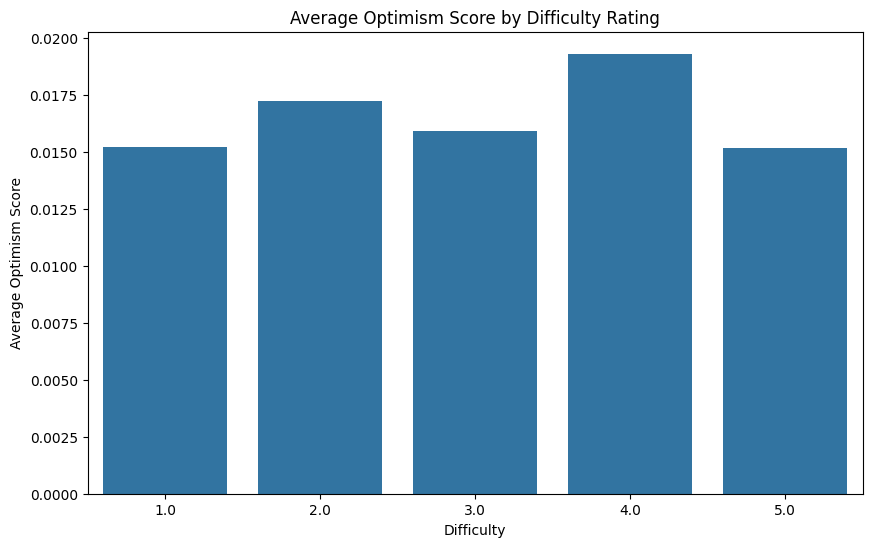

ANOVA Table for optimism based on Quality:
               sum_sq      df         F        PR(>F)
C(Quality)   0.153220     8.0  5.727883  2.672688e-07
Residual    33.410546  9992.0       NaN           NaN

Regression Summary for optimism based on Quality:
                            OLS Regression Results                            
Dep. Variable:               optimism   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.728
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           2.67e-07
Time:                        00:02:38   Log-Likelihood:                 14320.
No. Observations:               10001   AIC:                        -2.862e+04
Df Residuals:                    9992   BIC:                        -2.856e+04
Df Model:                           8                                         
Covariance Type:            nonro

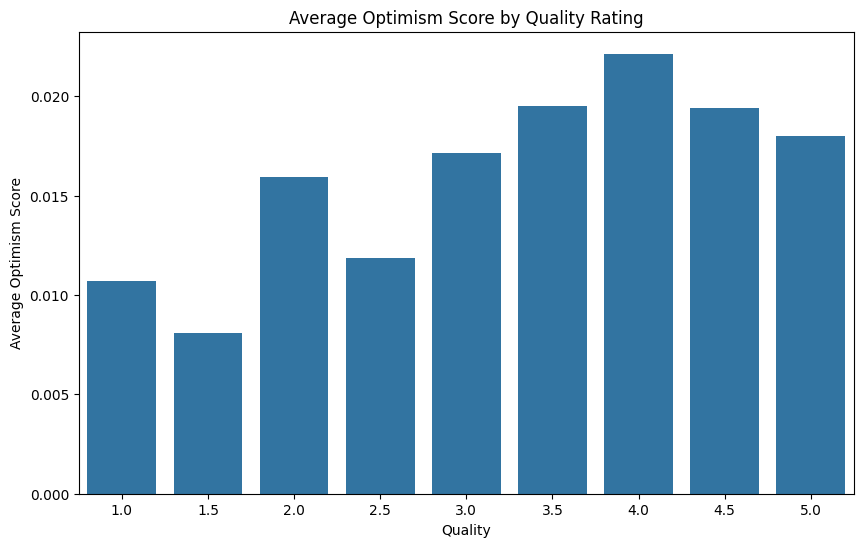

ANOVA Table for neutral based on Difficulty:
                   sum_sq      df          F        PR(>F)
C(Difficulty)    5.428751     4.0  20.572324  6.691477e-17
Residual       659.451472  9996.0        NaN           NaN

Regression Summary for neutral based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                neutral   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     20.57
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           6.69e-17
Time:                        00:02:38   Log-Likelihood:                -594.28
No. Observations:               10001   AIC:                             1199.
Df Residuals:                    9996   BIC:                             1235.
Df Model:                           4                                         
Covariance Typ

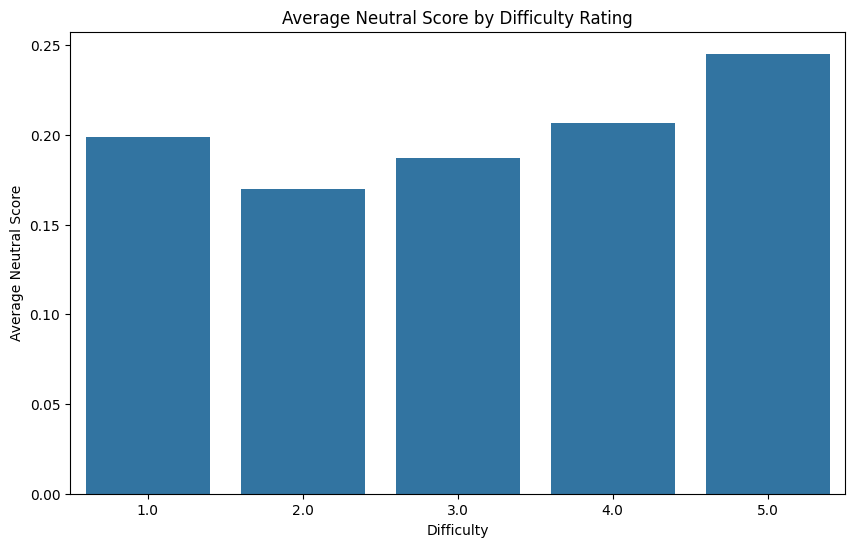

ANOVA Table for neutral based on Quality:
                sum_sq      df          F         PR(>F)
C(Quality)   34.182007     8.0  67.692164  8.686472e-109
Residual    630.698216  9992.0        NaN            NaN

Regression Summary for neutral based on Quality:
                            OLS Regression Results                            
Dep. Variable:                neutral   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     67.69
Date:                Mon, 03 Jun 2024   Prob (F-statistic):          8.69e-109
Time:                        00:02:38   Log-Likelihood:                -371.36
No. Observations:               10001   AIC:                             760.7
Df Residuals:                    9992   BIC:                             825.6
Df Model:                           8                                         
Covariance Type:          

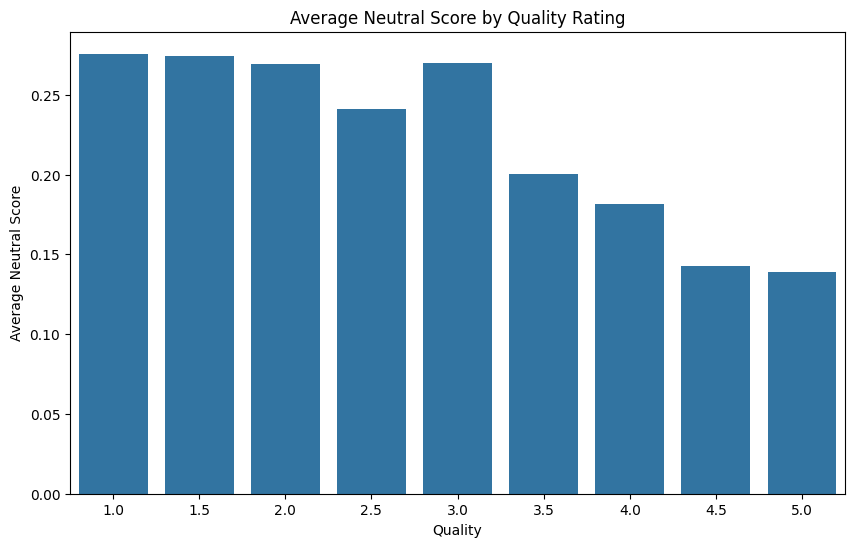

ANOVA Table for excitement based on Difficulty:
                  sum_sq      df         F    PR(>F)
C(Difficulty)   0.025852     4.0  4.539554  0.001157
Residual       14.231582  9996.0       NaN       NaN

Regression Summary for excitement based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:             excitement   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.540
Date:                Mon, 03 Jun 2024   Prob (F-statistic):            0.00116
Time:                        00:02:38   Log-Likelihood:                 18587.
No. Observations:               10001   AIC:                        -3.716e+04
Df Residuals:                    9996   BIC:                        -3.713e+04
Df Model:                           4                                         
Covariance Type:          

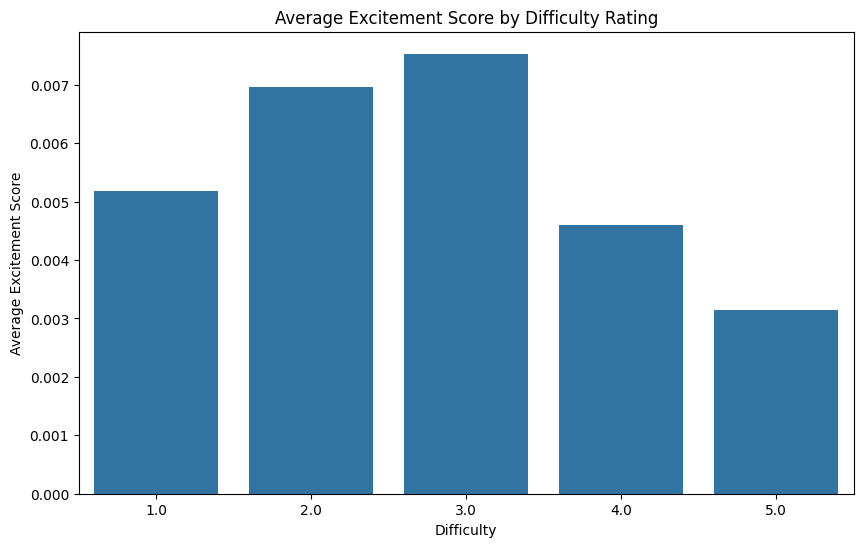

ANOVA Table for excitement based on Quality:
               sum_sq      df         F    PR(>F)
C(Quality)   0.051794     8.0  4.553906  0.000015
Residual    14.205640  9992.0       NaN       NaN

Regression Summary for excitement based on Quality:
                            OLS Regression Results                            
Dep. Variable:             excitement   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.554
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           1.50e-05
Time:                        00:02:39   Log-Likelihood:                 18596.
No. Observations:               10001   AIC:                        -3.717e+04
Df Residuals:                    9992   BIC:                        -3.711e+04
Df Model:                           8                                         
Covariance Type:            nonrobust    

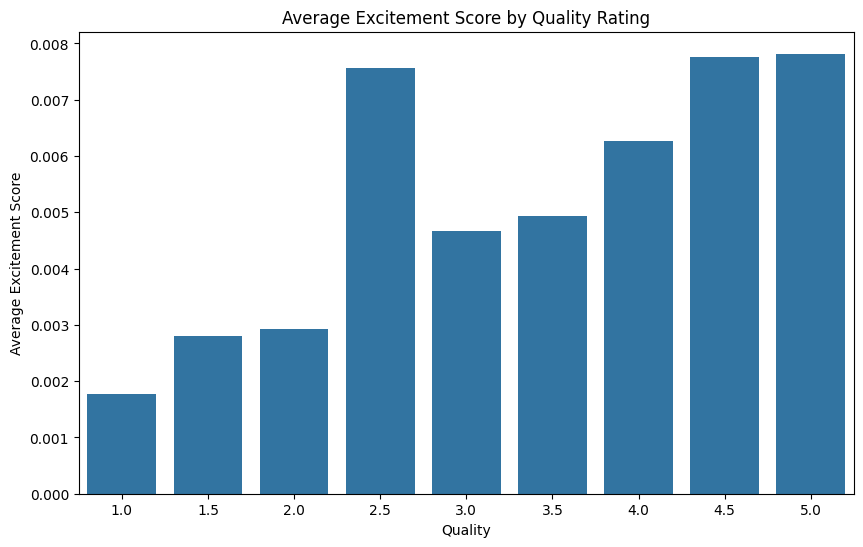

ANOVA Table for love based on Difficulty:
                   sum_sq      df          F        PR(>F)
C(Difficulty)    0.596509     4.0  10.251963  2.781613e-08
Residual       145.403949  9996.0        NaN           NaN

Regression Summary for love based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                   love   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     10.25
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           2.78e-08
Time:                        00:02:39   Log-Likelihood:                 6965.9
No. Observations:               10001   AIC:                        -1.392e+04
Df Residuals:                    9996   BIC:                        -1.389e+04
Df Model:                           4                                         
Covariance Type:    

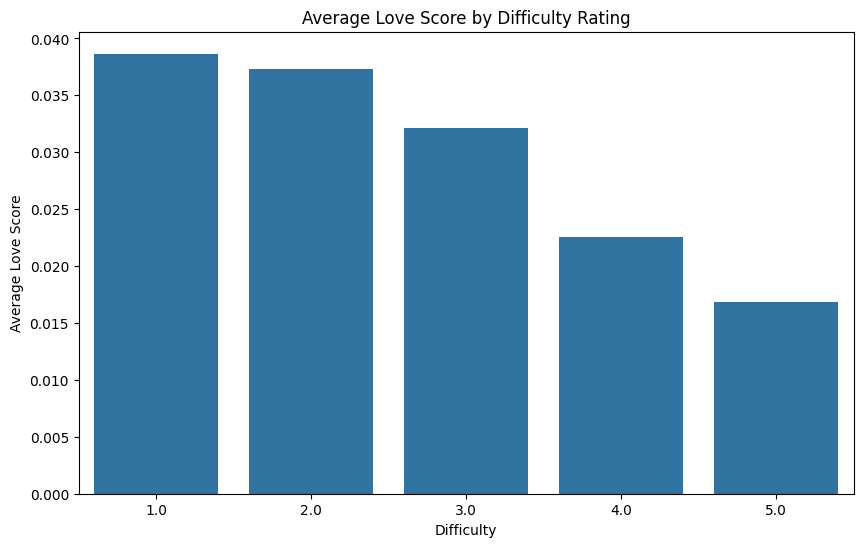

ANOVA Table for love based on Quality:
                sum_sq      df          F        PR(>F)
C(Quality)    2.266438     8.0  19.694579  9.157856e-30
Residual    143.734020  9992.0        NaN           NaN

Regression Summary for love based on Quality:
                            OLS Regression Results                            
Dep. Variable:                   love   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     19.69
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           9.16e-30
Time:                        00:02:39   Log-Likelihood:                 7023.7
No. Observations:               10001   AIC:                        -1.403e+04
Df Residuals:                    9992   BIC:                        -1.396e+04
Df Model:                           8                                         
Covariance Type:            nonrobu

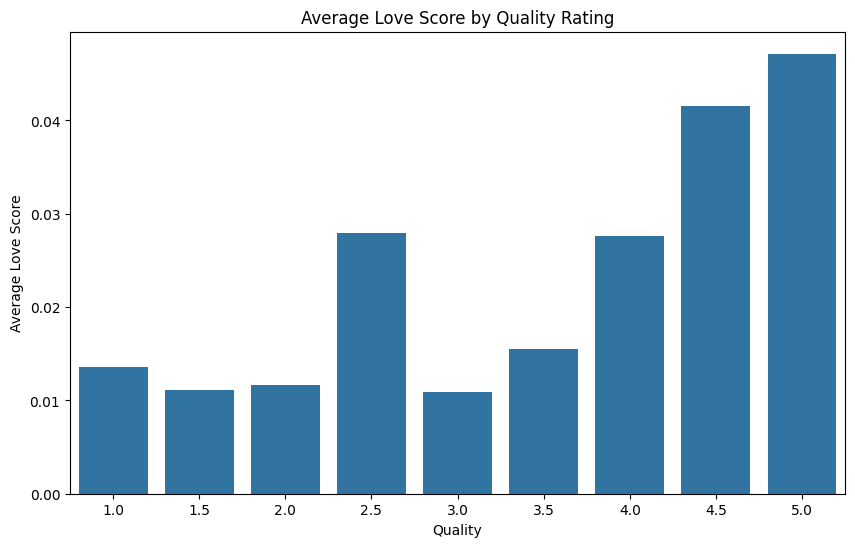

ANOVA Table for gratitude based on Difficulty:
                  sum_sq      df         F    PR(>F)
C(Difficulty)   0.012272     4.0  1.132625  0.339014
Residual       27.077272  9996.0       NaN       NaN

Regression Summary for gratitude based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:              gratitude   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.133
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.339
Time:                        00:02:40   Log-Likelihood:                 15371.
No. Observations:               10001   AIC:                        -3.073e+04
Df Residuals:                    9996   BIC:                        -3.070e+04
Df Model:                           4                                         
Covariance Type:            

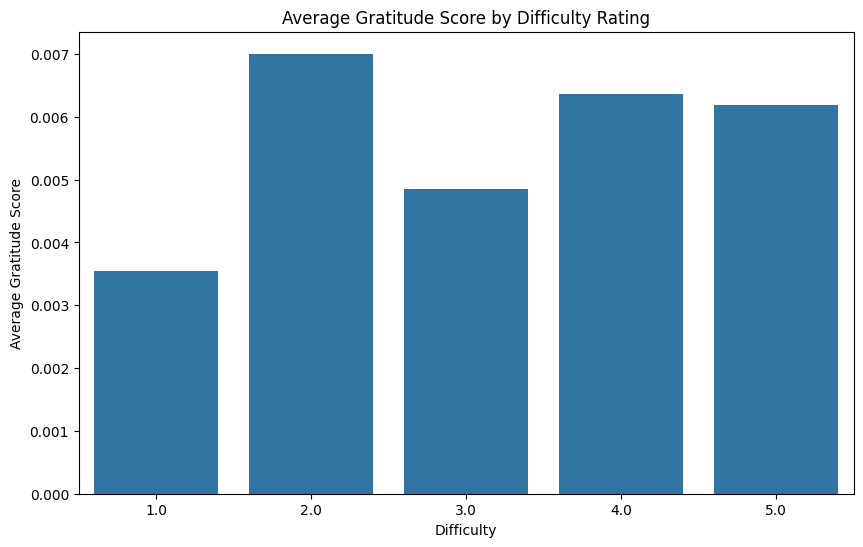

ANOVA Table for gratitude based on Quality:
               sum_sq      df         F    PR(>F)
C(Quality)   0.063110     8.0  2.916582  0.002985
Residual    27.026434  9992.0       NaN       NaN

Regression Summary for gratitude based on Quality:
                            OLS Regression Results                            
Dep. Variable:              gratitude   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.917
Date:                Mon, 03 Jun 2024   Prob (F-statistic):            0.00299
Time:                        00:02:40   Log-Likelihood:                 15380.
No. Observations:               10001   AIC:                        -3.074e+04
Df Residuals:                    9992   BIC:                        -3.068e+04
Df Model:                           8                                         
Covariance Type:            nonrobust      

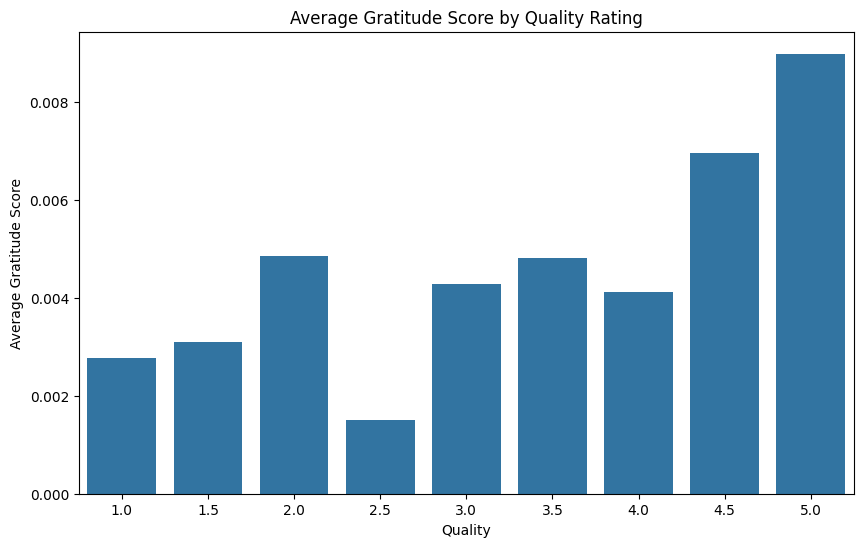

ANOVA Table for joy based on Difficulty:
                   sum_sq      df          F        PR(>F)
C(Difficulty)    3.560347     4.0  33.226865  1.422489e-27
Residual       267.774486  9996.0        NaN           NaN

Regression Summary for joy based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                    joy   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     33.23
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           1.42e-27
Time:                        00:02:40   Log-Likelihood:                 3912.5
No. Observations:               10001   AIC:                            -7815.
Df Residuals:                    9996   BIC:                            -7779.
Df Model:                           4                                         
Covariance Type:      

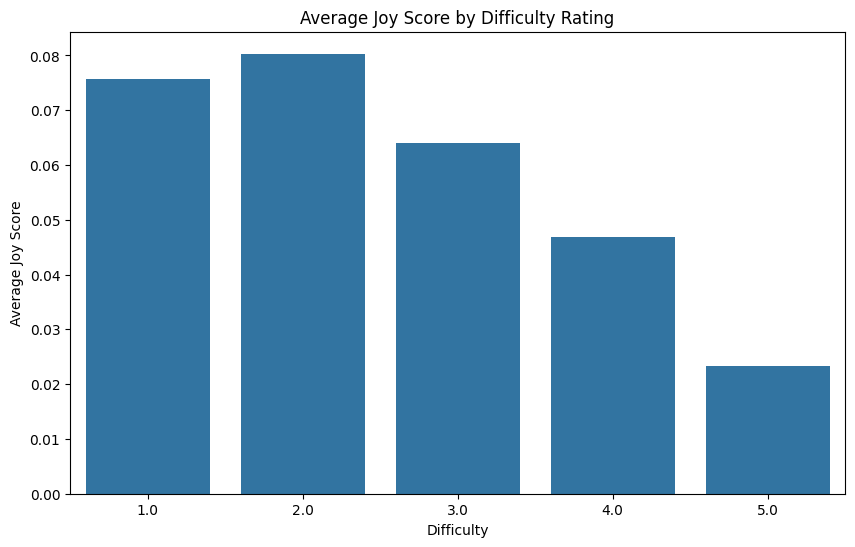

ANOVA Table for joy based on Quality:
                sum_sq      df      F        PR(>F)
C(Quality)    7.767738     8.0  36.81  4.743897e-58
Residual    263.567095  9992.0    NaN           NaN

Regression Summary for joy based on Quality:
                            OLS Regression Results                            
Dep. Variable:                    joy   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     36.81
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           4.74e-58
Time:                        00:02:40   Log-Likelihood:                 3991.7
No. Observations:               10001   AIC:                            -7965.
Df Residuals:                    9992   BIC:                            -7900.
Df Model:                           8                                         
Covariance Type:            nonrobust            

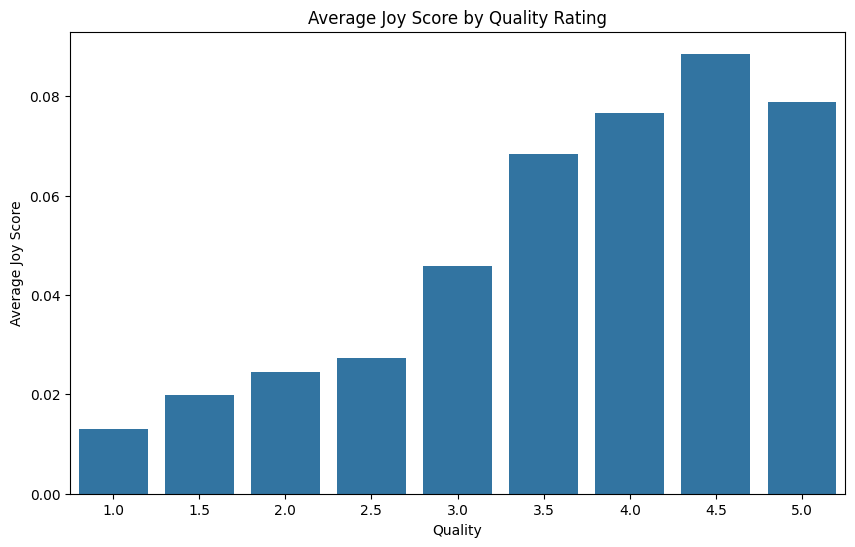

ANOVA Table for desire based on Difficulty:
                  sum_sq      df        F    PR(>F)
C(Difficulty)   0.007777     4.0  0.67187  0.611424
Residual       28.926937  9996.0      NaN       NaN

Regression Summary for desire based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                 desire   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6719
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.611
Time:                        00:02:40   Log-Likelihood:                 15040.
No. Observations:               10001   AIC:                        -3.007e+04
Df Residuals:                    9996   BIC:                        -3.003e+04
Df Model:                           4                                         
Covariance Type:            nonrobust

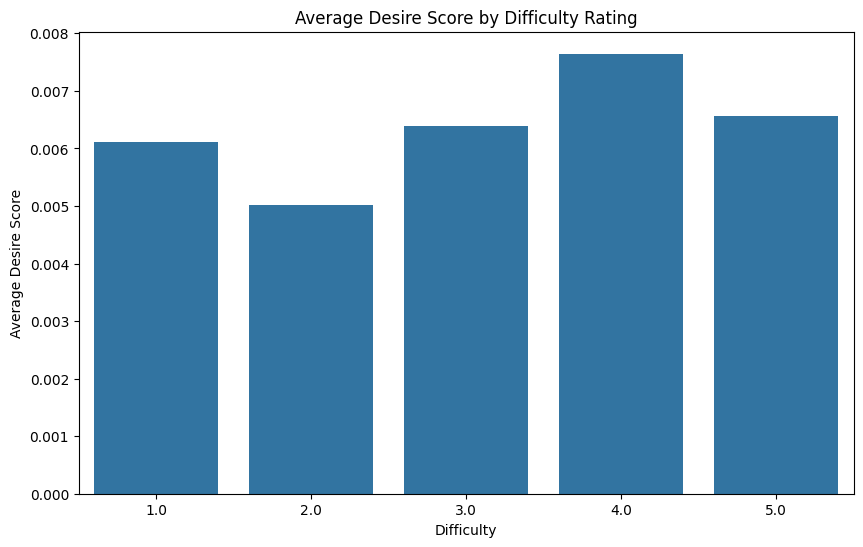

ANOVA Table for desire based on Quality:
               sum_sq      df         F    PR(>F)
C(Quality)   0.026972     8.0  1.165362  0.315917
Residual    28.907742  9992.0       NaN       NaN

Regression Summary for desire based on Quality:
                            OLS Regression Results                            
Dep. Variable:                 desire   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.165
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.316
Time:                        00:02:40   Log-Likelihood:                 15044.
No. Observations:               10001   AIC:                        -3.007e+04
Df Residuals:                    9992   BIC:                        -3.000e+04
Df Model:                           8                                         
Covariance Type:            nonrobust            

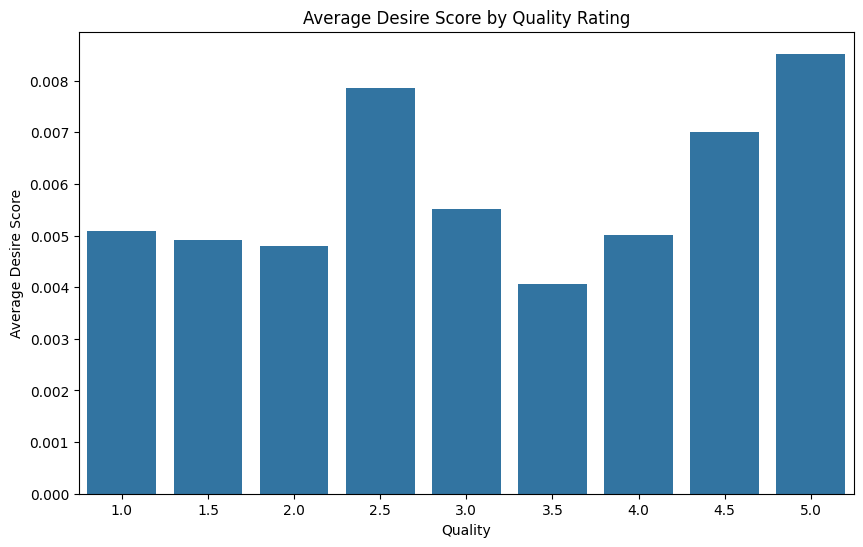

ANOVA Table for amusement based on Difficulty:
                   sum_sq      df         F        PR(>F)
C(Difficulty)    0.867782     4.0  12.96167  1.580151e-10
Residual       167.307781  9996.0       NaN           NaN

Regression Summary for amusement based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:              amusement   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     12.96
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           1.58e-10
Time:                        00:02:40   Log-Likelihood:                 6264.3
No. Observations:               10001   AIC:                        -1.252e+04
Df Residuals:                    9996   BIC:                        -1.248e+04
Df Model:                           4                                         
Covariance Ty

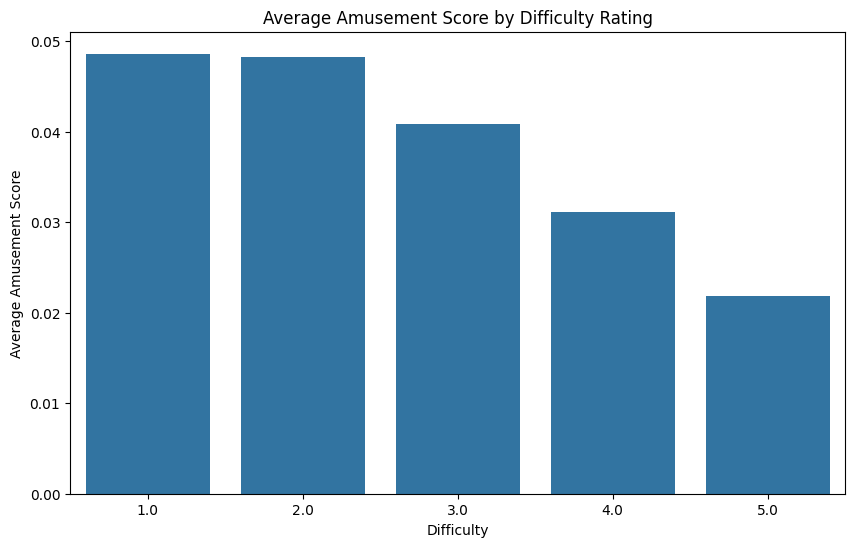

ANOVA Table for amusement based on Quality:
                sum_sq      df          F        PR(>F)
C(Quality)    1.833155     8.0  13.764446  4.719729e-20
Residual    166.342408  9992.0        NaN           NaN

Regression Summary for amusement based on Quality:
                            OLS Regression Results                            
Dep. Variable:              amusement   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     13.76
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           4.72e-20
Time:                        00:02:41   Log-Likelihood:                 6293.2
No. Observations:               10001   AIC:                        -1.257e+04
Df Residuals:                    9992   BIC:                        -1.250e+04
Df Model:                           8                                         
Covariance Type:         

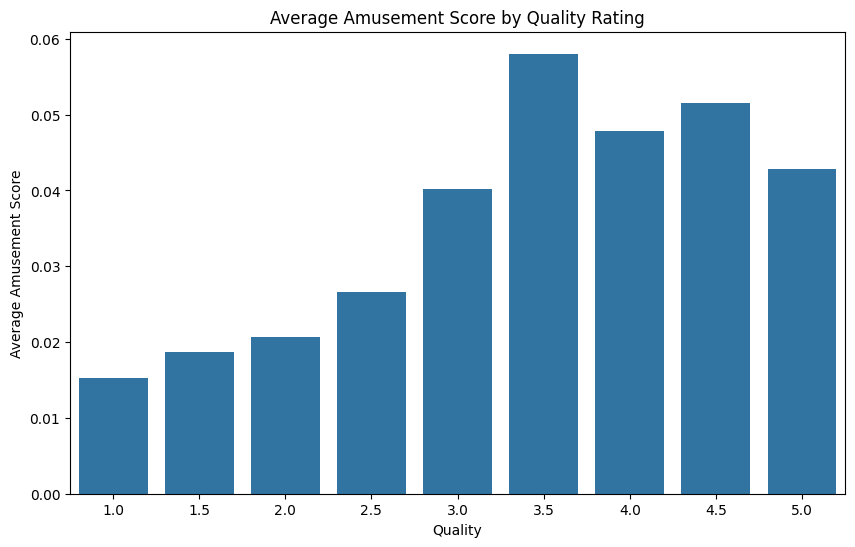

ANOVA Table for caring based on Difficulty:
                  sum_sq      df       F    PR(>F)
C(Difficulty)   0.085141     4.0  3.2916  0.010524
Residual       64.639618  9996.0     NaN       NaN

Regression Summary for caring based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                 caring   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.292
Date:                Mon, 03 Jun 2024   Prob (F-statistic):             0.0105
Time:                        00:02:41   Log-Likelihood:                 11020.
No. Observations:               10001   AIC:                        -2.203e+04
Df Residuals:                    9996   BIC:                        -2.199e+04
Df Model:                           4                                         
Covariance Type:            nonrobust   

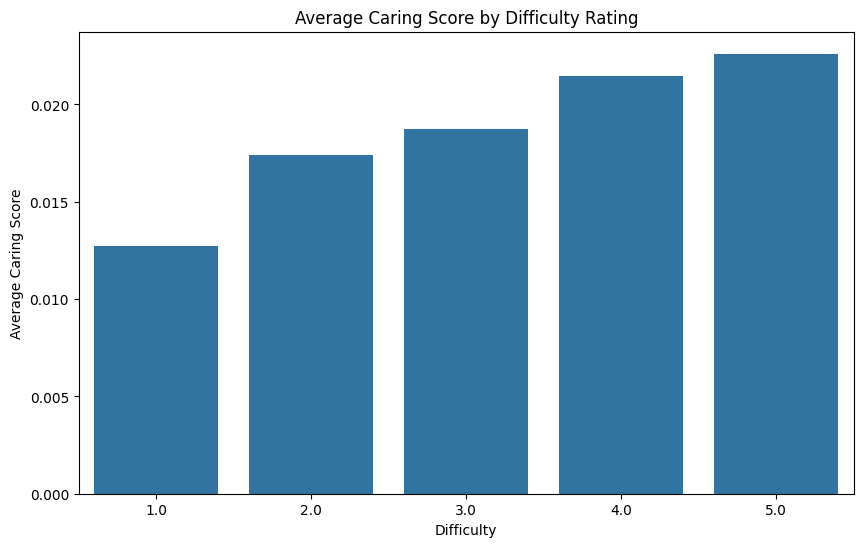

ANOVA Table for caring based on Quality:
               sum_sq      df         F    PR(>F)
C(Quality)   0.090008     8.0  1.739316  0.084168
Residual    64.634751  9992.0       NaN       NaN

Regression Summary for caring based on Quality:
                            OLS Regression Results                            
Dep. Variable:                 caring   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.739
Date:                Mon, 03 Jun 2024   Prob (F-statistic):             0.0842
Time:                        00:02:41   Log-Likelihood:                 11020.
No. Observations:               10001   AIC:                        -2.202e+04
Df Residuals:                    9992   BIC:                        -2.196e+04
Df Model:                           8                                         
Covariance Type:            nonrobust            

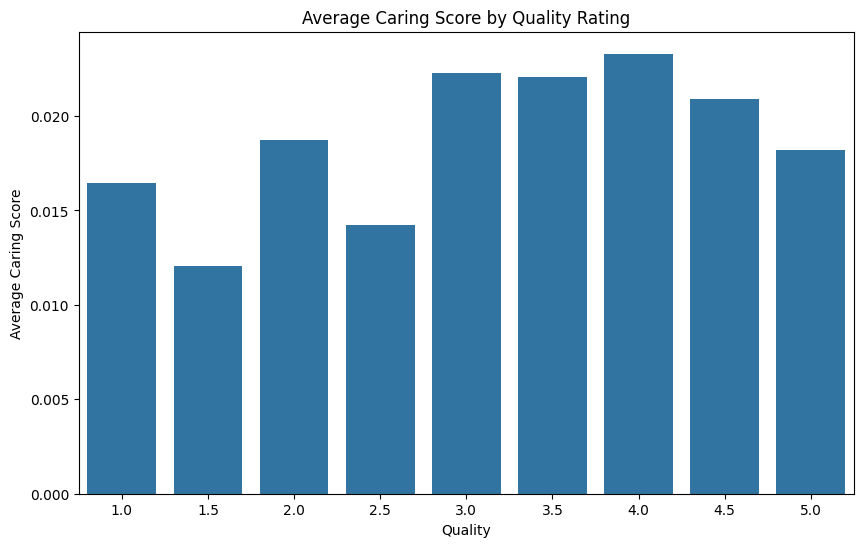

ANOVA Table for disapproval based on Difficulty:
                   sum_sq      df          F        PR(>F)
C(Difficulty)    5.486605     4.0  99.502729  3.415701e-83
Residual       137.795475  9996.0        NaN           NaN

Regression Summary for disapproval based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:            disapproval   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     99.50
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           3.42e-83
Time:                        00:02:41   Log-Likelihood:                 7234.7
No. Observations:               10001   AIC:                        -1.446e+04
Df Residuals:                    9996   BIC:                        -1.442e+04
Df Model:                           4                                         
Covari

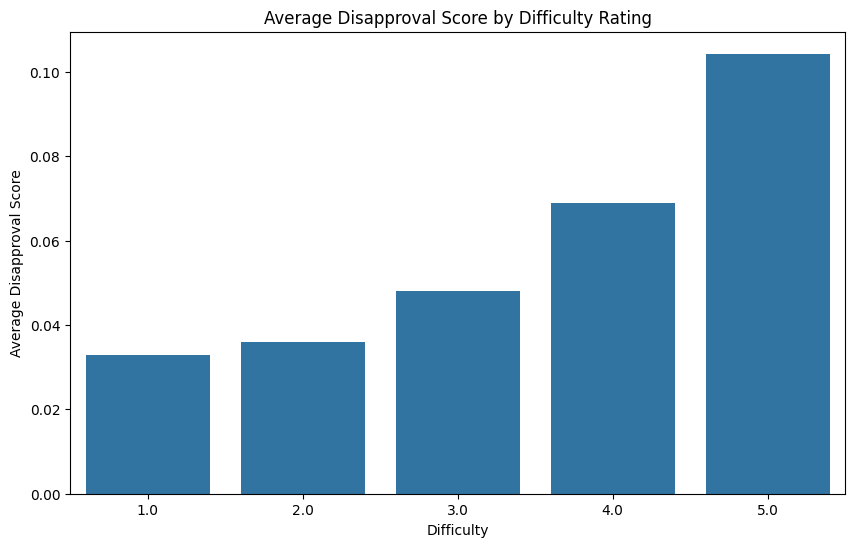

ANOVA Table for disapproval based on Quality:
                sum_sq      df           F         PR(>F)
C(Quality)   18.387194     8.0  183.879475  4.440704e-291
Residual    124.894885  9992.0         NaN            NaN

Regression Summary for disapproval based on Quality:
                            OLS Regression Results                            
Dep. Variable:            disapproval   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     183.9
Date:                Mon, 03 Jun 2024   Prob (F-statistic):          4.44e-291
Time:                        00:02:41   Log-Likelihood:                 7726.2
No. Observations:               10001   AIC:                        -1.543e+04
Df Residuals:                    9992   BIC:                        -1.537e+04
Df Model:                           8                                         
Covariance Type

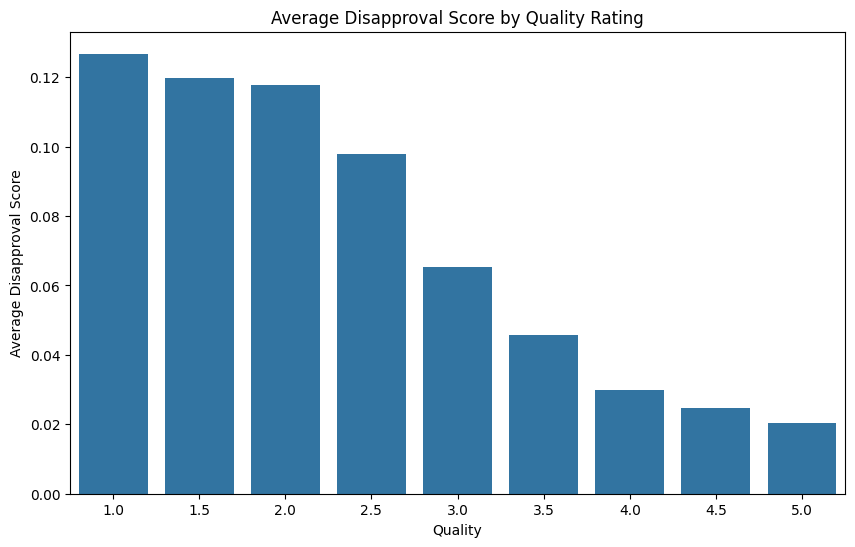

ANOVA Table for annoyance based on Difficulty:
                   sum_sq      df           F        PR(>F)
C(Difficulty)    8.991619     4.0  101.954605  3.136413e-85
Residual       220.392753  9996.0         NaN           NaN

Regression Summary for annoyance based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:              annoyance   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     102.0
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           3.14e-85
Time:                        00:02:42   Log-Likelihood:                 4886.2
No. Observations:               10001   AIC:                            -9762.
Df Residuals:                    9996   BIC:                            -9726.
Df Model:                           4                                         
Covaria

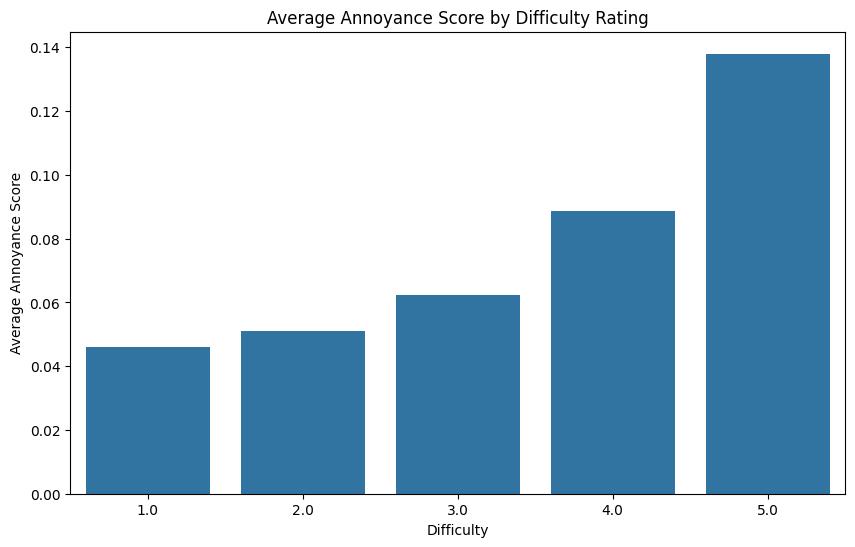

ANOVA Table for annoyance based on Quality:
                sum_sq      df           F  PR(>F)
C(Quality)   42.886867     8.0  287.219372     0.0
Residual    186.497506  9992.0         NaN     NaN

Regression Summary for annoyance based on Quality:
                            OLS Regression Results                            
Dep. Variable:              annoyance   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     287.2
Date:                Mon, 03 Jun 2024   Prob (F-statistic):               0.00
Time:                        00:02:42   Log-Likelihood:                 5721.3
No. Observations:               10001   AIC:                        -1.142e+04
Df Residuals:                    9992   BIC:                        -1.136e+04
Df Model:                           8                                         
Covariance Type:            nonrobust   

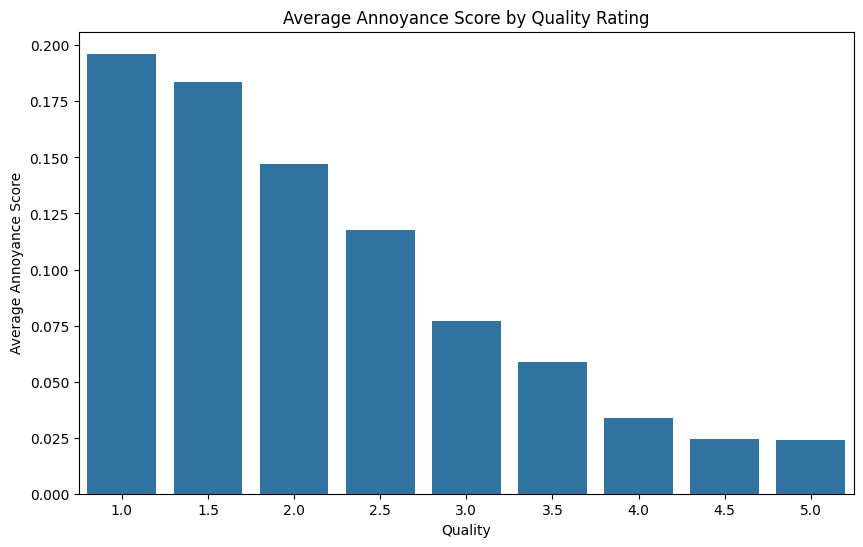

ANOVA Table for disappointment based on Difficulty:
                   sum_sq      df          F        PR(>F)
C(Difficulty)    1.114151     4.0  19.965008  2.168654e-16
Residual       139.457112  9996.0        NaN           NaN

Regression Summary for disappointment based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:         disappointment   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     19.97
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           2.17e-16
Time:                        00:02:42   Log-Likelihood:                 7174.7
No. Observations:               10001   AIC:                        -1.434e+04
Df Residuals:                    9996   BIC:                        -1.430e+04
Df Model:                           4                                         


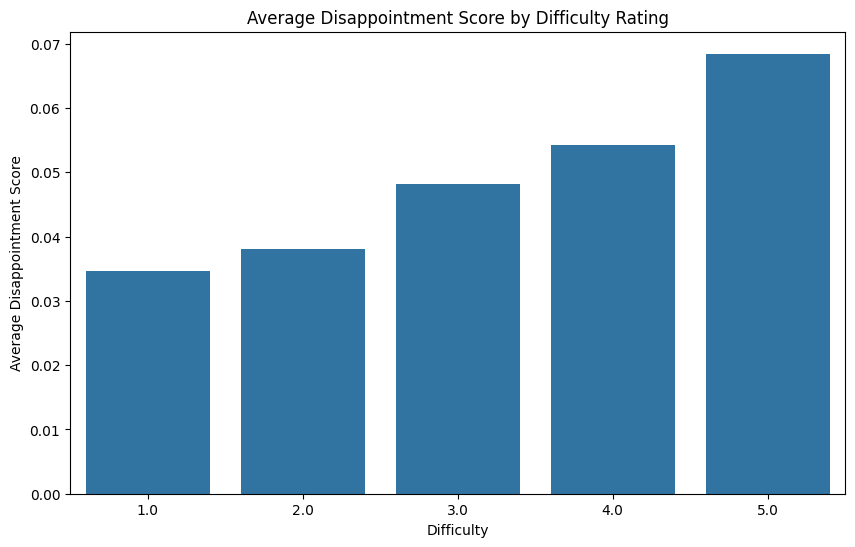

ANOVA Table for disappointment based on Quality:
                sum_sq      df           F         PR(>F)
C(Quality)   10.692173     8.0  102.822745  2.069144e-165
Residual    129.879089  9992.0         NaN            NaN

Regression Summary for disappointment based on Quality:
                            OLS Regression Results                            
Dep. Variable:         disappointment   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     102.8
Date:                Mon, 03 Jun 2024   Prob (F-statistic):          2.07e-165
Time:                        00:02:42   Log-Likelihood:                 7530.5
No. Observations:               10001   AIC:                        -1.504e+04
Df Residuals:                    9992   BIC:                        -1.498e+04
Df Model:                           8                                         
Covarianc

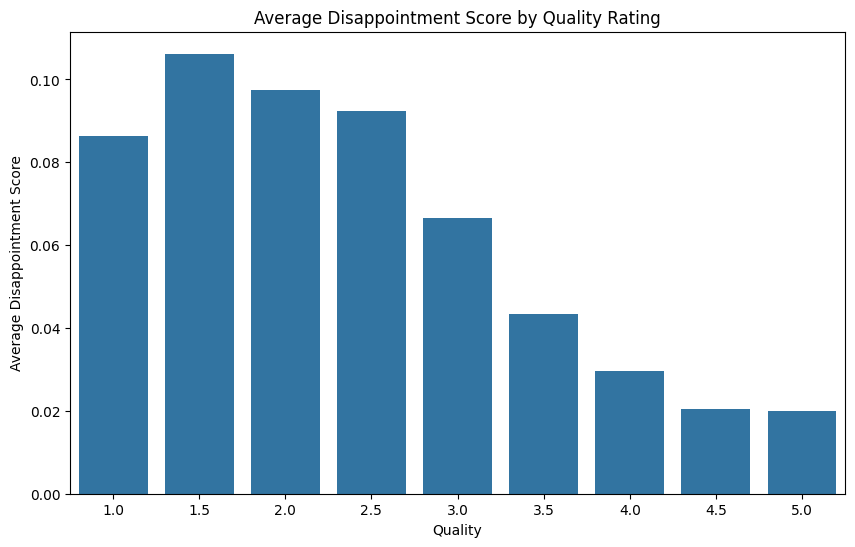

ANOVA Table for realization based on Difficulty:
                  sum_sq      df         F   PR(>F)
C(Difficulty)   0.008359     4.0  1.525776  0.19167
Residual       13.690688  9996.0       NaN      NaN

Regression Summary for realization based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:            realization   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.526
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.192
Time:                        00:02:42   Log-Likelihood:                 18781.
No. Observations:               10001   AIC:                        -3.755e+04
Df Residuals:                    9996   BIC:                        -3.752e+04
Df Model:                           4                                         
Covariance Type:           

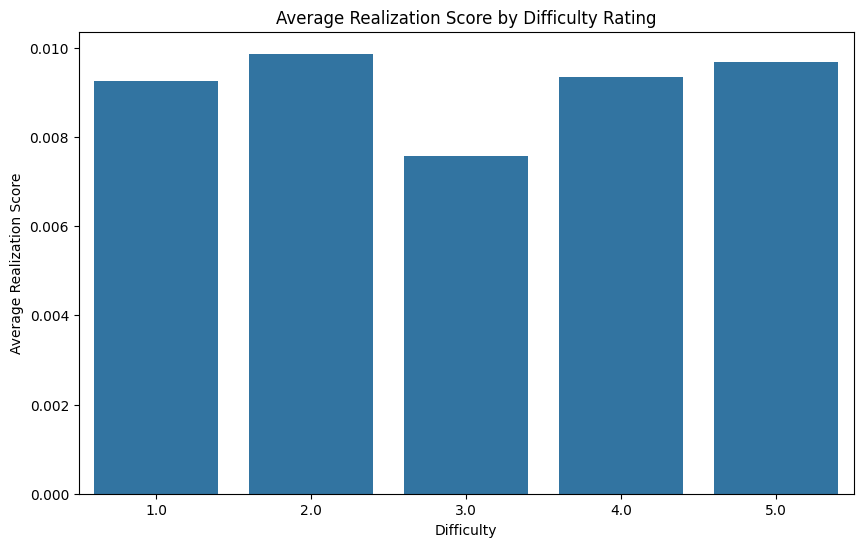

ANOVA Table for realization based on Quality:
               sum_sq      df         F        PR(>F)
C(Quality)   0.075336     8.0  6.906656  4.188610e-09
Residual    13.623711  9992.0       NaN           NaN

Regression Summary for realization based on Quality:
                            OLS Regression Results                            
Dep. Variable:            realization   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     6.907
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           4.19e-09
Time:                        00:02:42   Log-Likelihood:                 18806.
No. Observations:               10001   AIC:                        -3.759e+04
Df Residuals:                    9992   BIC:                        -3.753e+04
Df Model:                           8                                         
Covariance Type:           

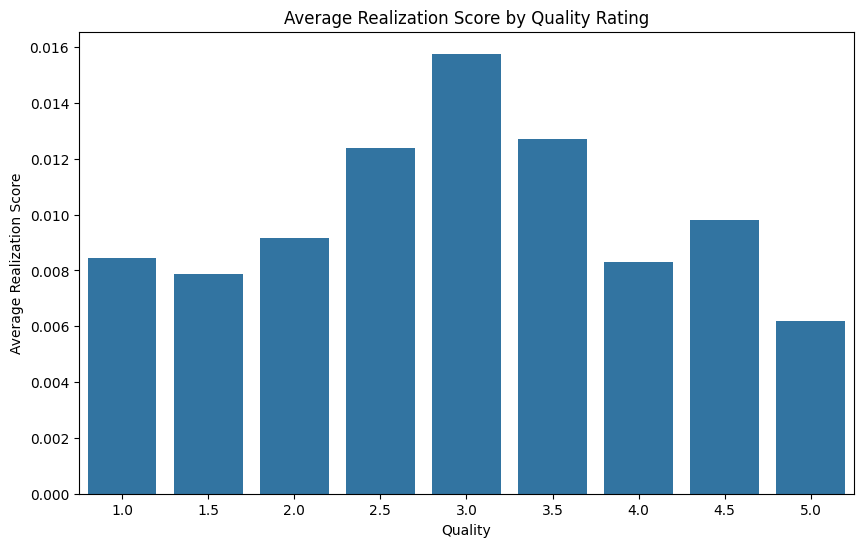

ANOVA Table for confusion based on Difficulty:
                   sum_sq      df         F   PR(>F)
C(Difficulty)    0.327423     4.0  6.746848  0.00002
Residual       121.275827  9996.0       NaN      NaN

Regression Summary for confusion based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:              confusion   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     6.747
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           2.03e-05
Time:                        00:02:43   Log-Likelihood:                 7873.3
No. Observations:               10001   AIC:                        -1.574e+04
Df Residuals:                    9996   BIC:                        -1.570e+04
Df Model:                           4                                         
Covariance Type:            

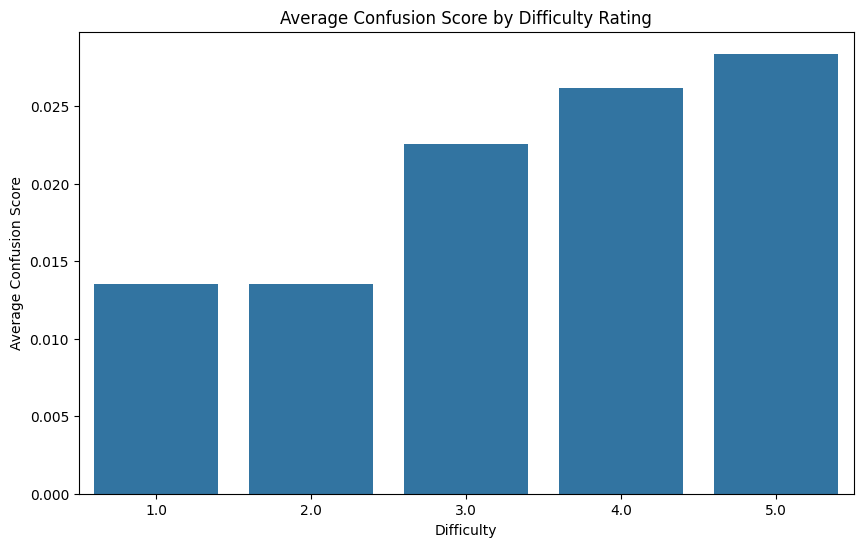

ANOVA Table for confusion based on Quality:
                sum_sq      df          F        PR(>F)
C(Quality)    2.439394     8.0  25.568186  1.862391e-39
Residual    119.163856  9992.0        NaN           NaN

Regression Summary for confusion based on Quality:
                            OLS Regression Results                            
Dep. Variable:              confusion   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     25.57
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           1.86e-39
Time:                        00:02:43   Log-Likelihood:                 7961.1
No. Observations:               10001   AIC:                        -1.590e+04
Df Residuals:                    9992   BIC:                        -1.584e+04
Df Model:                           8                                         
Covariance Type:         

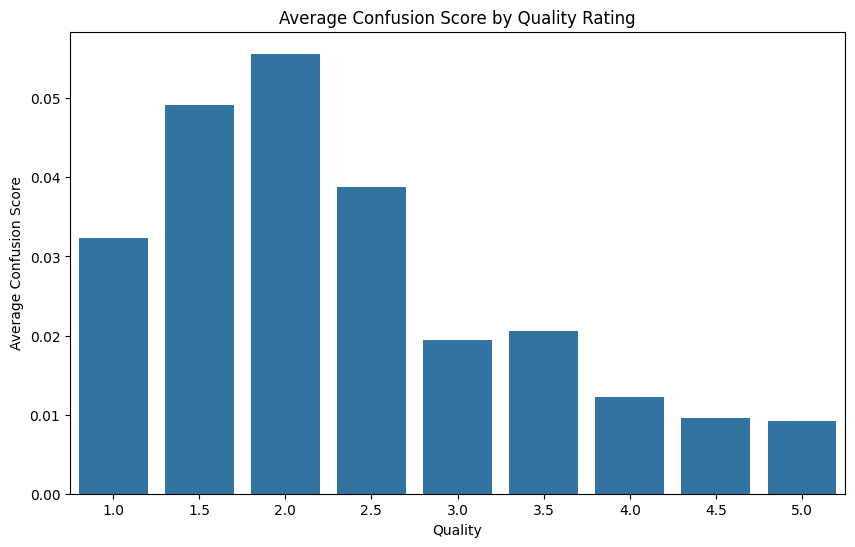

ANOVA Table for curiosity based on Difficulty:
                 sum_sq      df         F    PR(>F)
C(Difficulty)  0.000465     4.0  0.198006  0.939508
Residual       5.869007  9996.0       NaN       NaN

Regression Summary for curiosity based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:              curiosity   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1980
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.940
Time:                        00:02:43   Log-Likelihood:                 23017.
No. Observations:               10001   AIC:                        -4.602e+04
Df Residuals:                    9996   BIC:                        -4.599e+04
Df Model:                           4                                         
Covariance Type:            non

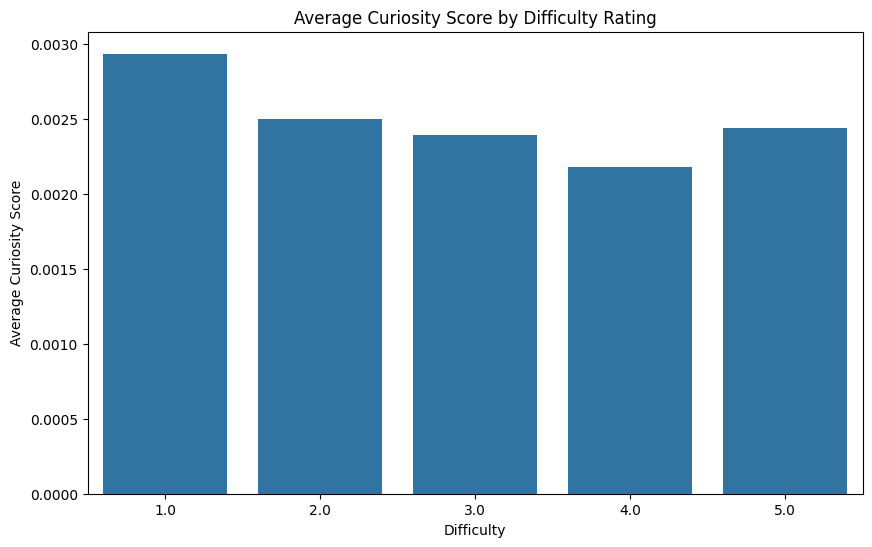

ANOVA Table for curiosity based on Quality:
              sum_sq      df         F    PR(>F)
C(Quality)  0.004095     8.0  0.871995  0.539266
Residual    5.865377  9992.0       NaN       NaN

Regression Summary for curiosity based on Quality:
                            OLS Regression Results                            
Dep. Variable:              curiosity   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8720
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.539
Time:                        00:02:43   Log-Likelihood:                 23020.
No. Observations:               10001   AIC:                        -4.602e+04
Df Residuals:                    9992   BIC:                        -4.596e+04
Df Model:                           8                                         
Covariance Type:            nonrobust         

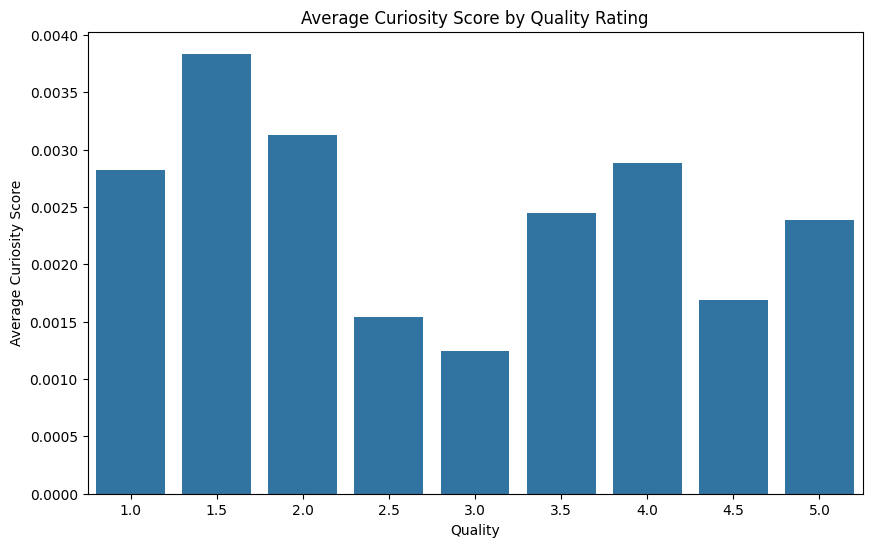

ANOVA Table for anger based on Difficulty:
                  sum_sq      df          F        PR(>F)
C(Difficulty)   0.543926     4.0  54.395222  1.954682e-45
Residual       24.988799  9996.0        NaN           NaN

Regression Summary for anger based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                  anger   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     54.40
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           1.95e-45
Time:                        00:02:43   Log-Likelihood:                 15772.
No. Observations:               10001   AIC:                        -3.153e+04
Df Residuals:                    9996   BIC:                        -3.150e+04
Df Model:                           4                                         
Covariance Type:     

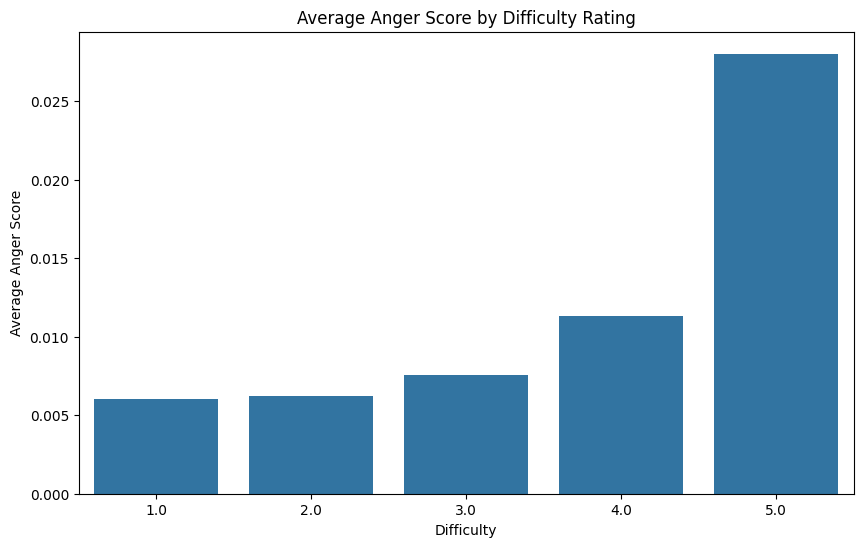

ANOVA Table for anger based on Quality:
               sum_sq      df          F         PR(>F)
C(Quality)   1.611173     8.0  84.123073  1.979009e-135
Residual    23.921552  9992.0        NaN            NaN

Regression Summary for anger based on Quality:
                            OLS Regression Results                            
Dep. Variable:                  anger   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     84.12
Date:                Mon, 03 Jun 2024   Prob (F-statistic):          1.98e-135
Time:                        00:02:43   Log-Likelihood:                 15991.
No. Observations:               10001   AIC:                        -3.196e+04
Df Residuals:                    9992   BIC:                        -3.190e+04
Df Model:                           8                                         
Covariance Type:            nonro

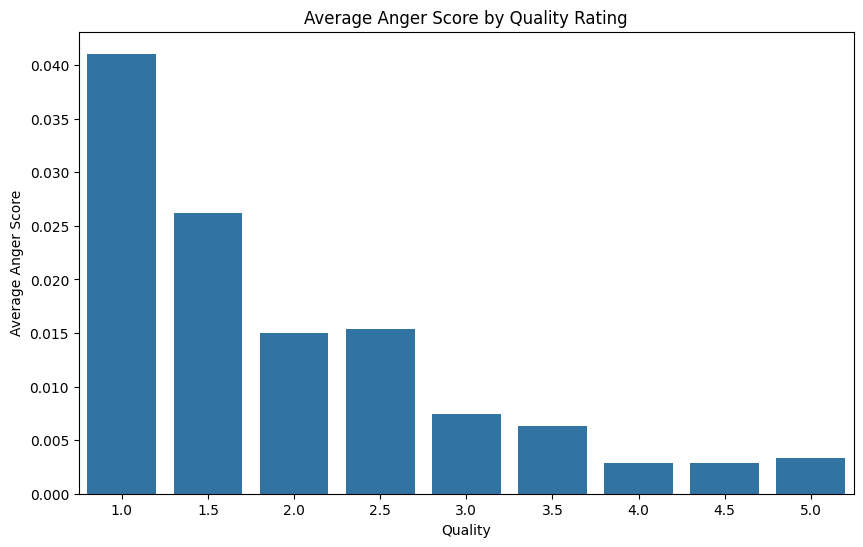

ANOVA Table for relief based on Difficulty:
                 sum_sq      df         F    PR(>F)
C(Difficulty)  0.000300     4.0  2.042119  0.085685
Residual       0.367406  9996.0       NaN       NaN

Regression Summary for relief based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                 relief   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.042
Date:                Mon, 03 Jun 2024   Prob (F-statistic):             0.0857
Time:                        00:02:44   Log-Likelihood:                 36873.
No. Observations:               10001   AIC:                        -7.374e+04
Df Residuals:                    9996   BIC:                        -7.370e+04
Df Model:                           4                                         
Covariance Type:            nonrobust

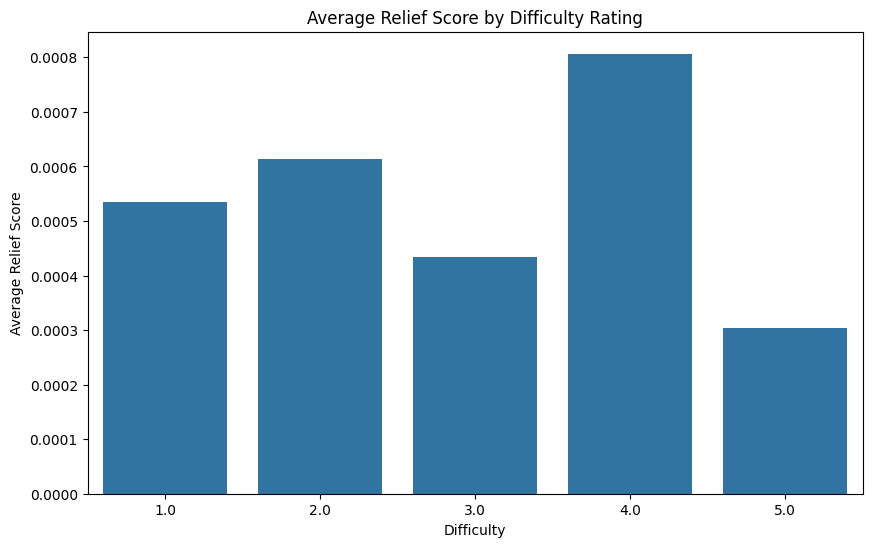

ANOVA Table for relief based on Quality:
              sum_sq      df         F    PR(>F)
C(Quality)  0.000571     8.0  1.942675  0.049557
Residual    0.367135  9992.0       NaN       NaN

Regression Summary for relief based on Quality:
                            OLS Regression Results                            
Dep. Variable:                 relief   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.943
Date:                Mon, 03 Jun 2024   Prob (F-statistic):             0.0496
Time:                        00:02:44   Log-Likelihood:                 36877.
No. Observations:               10001   AIC:                        -7.374e+04
Df Residuals:                    9992   BIC:                        -7.367e+04
Df Model:                           8                                         
Covariance Type:            nonrobust               

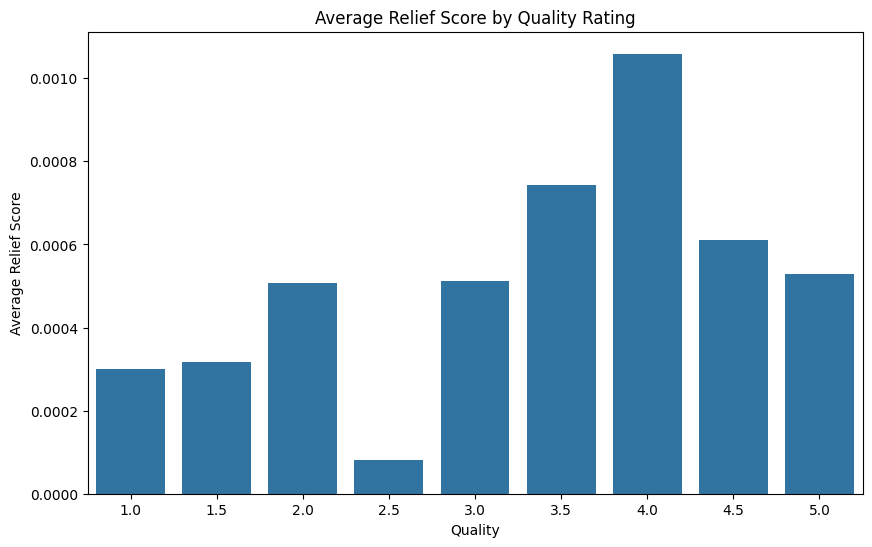

ANOVA Table for pride based on Difficulty:
                 sum_sq      df         F    PR(>F)
C(Difficulty)  0.000013     4.0  0.314148  0.868688
Residual       0.100546  9996.0       NaN       NaN

Regression Summary for pride based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                  pride   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3141
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.869
Time:                        00:02:44   Log-Likelihood:                 43353.
No. Observations:               10001   AIC:                        -8.670e+04
Df Residuals:                    9996   BIC:                        -8.666e+04
Df Model:                           4                                         
Covariance Type:            nonrobust  

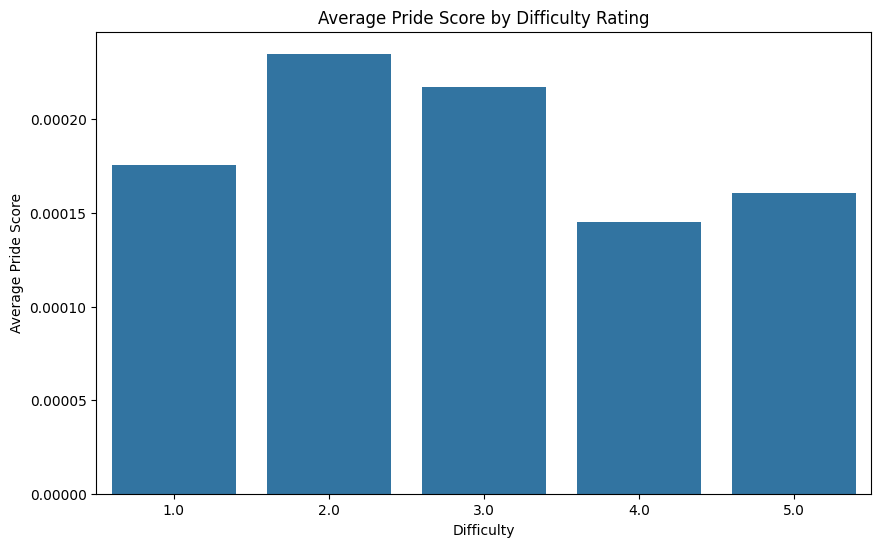

ANOVA Table for pride based on Quality:
              sum_sq      df         F   PR(>F)
C(Quality)  0.000150     8.0  1.869998  0.06006
Residual    0.100408  9992.0       NaN      NaN

Regression Summary for pride based on Quality:
                            OLS Regression Results                            
Dep. Variable:                  pride   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.870
Date:                Mon, 03 Jun 2024   Prob (F-statistic):             0.0601
Time:                        00:02:44   Log-Likelihood:                 43360.
No. Observations:               10001   AIC:                        -8.670e+04
Df Residuals:                    9992   BIC:                        -8.664e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                    

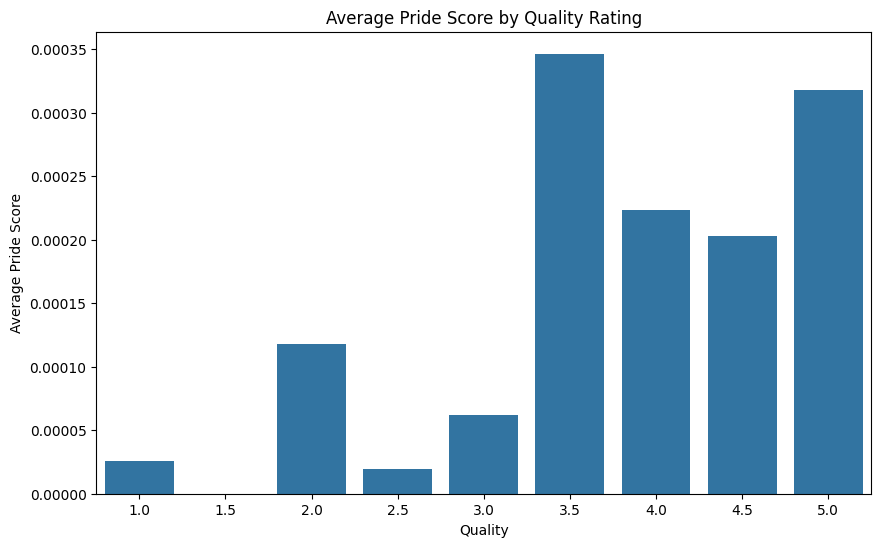

ANOVA Table for disgust based on Difficulty:
                  sum_sq      df          F        PR(>F)
C(Difficulty)   0.186594     4.0  22.535136  1.491297e-18
Residual       20.692061  9996.0        NaN           NaN

Regression Summary for disgust based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                disgust   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     22.54
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           1.49e-18
Time:                        00:02:44   Log-Likelihood:                 16716.
No. Observations:               10001   AIC:                        -3.342e+04
Df Residuals:                    9996   BIC:                        -3.339e+04
Df Model:                           4                                         
Covariance Type: 

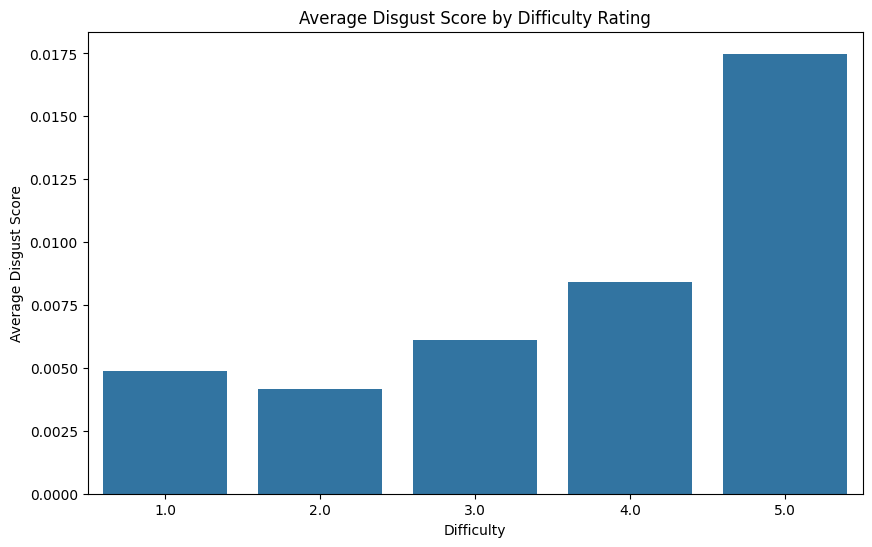

ANOVA Table for disgust based on Quality:
               sum_sq      df          F        PR(>F)
C(Quality)   0.975283     8.0  61.202127  3.432798e-98
Residual    19.903372  9992.0        NaN           NaN

Regression Summary for disgust based on Quality:
                            OLS Regression Results                            
Dep. Variable:                disgust   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     61.20
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           3.43e-98
Time:                        00:02:44   Log-Likelihood:                 16910.
No. Observations:               10001   AIC:                        -3.380e+04
Df Residuals:                    9992   BIC:                        -3.374e+04
Df Model:                           8                                         
Covariance Type:            nonr

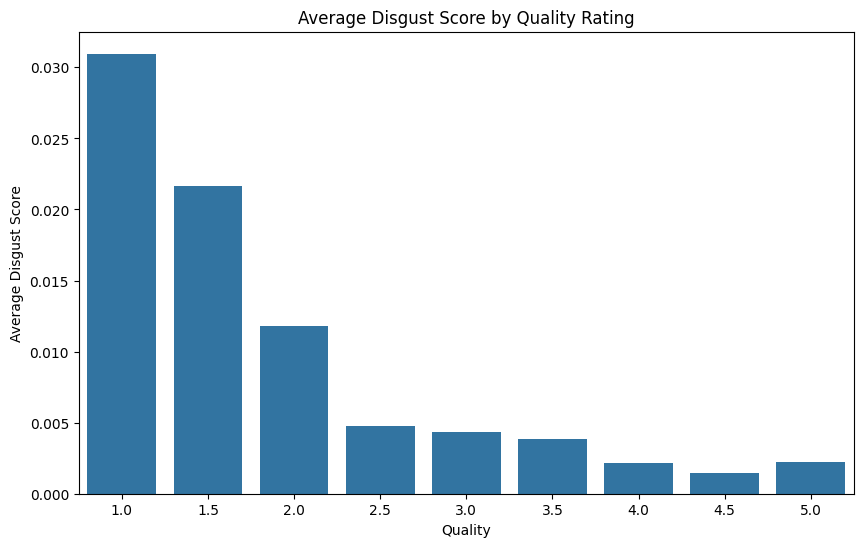

ANOVA Table for remorse based on Difficulty:
                  sum_sq      df         F    PR(>F)
C(Difficulty)   0.005434     4.0  1.320832  0.259523
Residual       10.281116  9996.0       NaN       NaN

Regression Summary for remorse based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                remorse   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.321
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.260
Time:                        00:02:45   Log-Likelihood:                 20213.
No. Observations:               10001   AIC:                        -4.042e+04
Df Residuals:                    9996   BIC:                        -4.038e+04
Df Model:                           4                                         
Covariance Type:            nonr

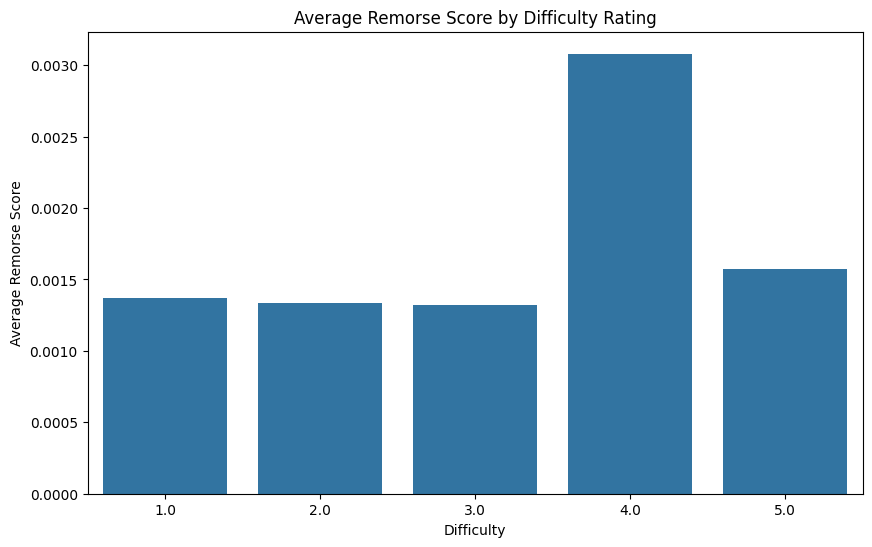

ANOVA Table for remorse based on Quality:
               sum_sq      df         F    PR(>F)
C(Quality)   0.025771     8.0  3.136983  0.001512
Residual    10.260779  9992.0       NaN       NaN

Regression Summary for remorse based on Quality:
                            OLS Regression Results                            
Dep. Variable:                remorse   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.137
Date:                Mon, 03 Jun 2024   Prob (F-statistic):            0.00151
Time:                        00:02:45   Log-Likelihood:                 20223.
No. Observations:               10001   AIC:                        -4.043e+04
Df Residuals:                    9992   BIC:                        -4.036e+04
Df Model:                           8                                         
Covariance Type:            nonrobust          

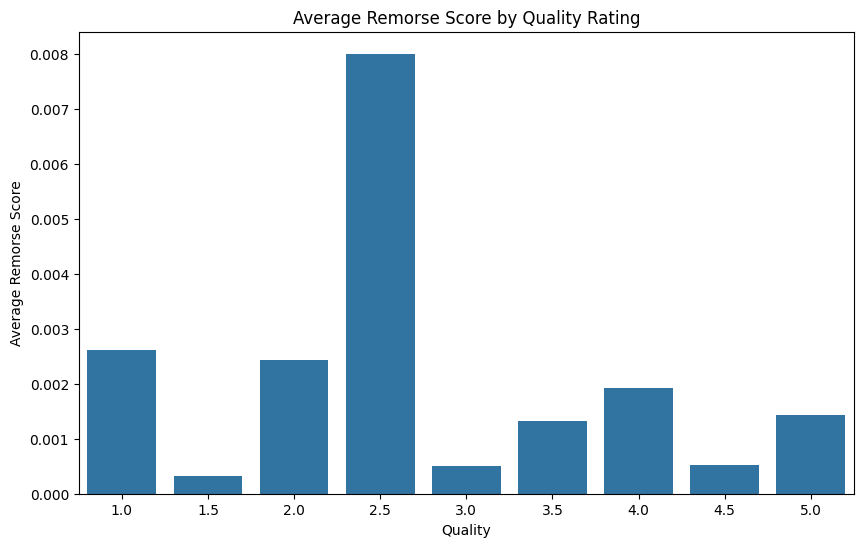

ANOVA Table for sadness based on Difficulty:
                  sum_sq      df         F    PR(>F)
C(Difficulty)   0.004995     4.0  0.745454  0.560898
Residual       16.745114  9996.0       NaN       NaN

Regression Summary for sadness based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                sadness   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7455
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.561
Time:                        00:02:45   Log-Likelihood:                 17774.
No. Observations:               10001   AIC:                        -3.554e+04
Df Residuals:                    9996   BIC:                        -3.550e+04
Df Model:                           4                                         
Covariance Type:            nonr

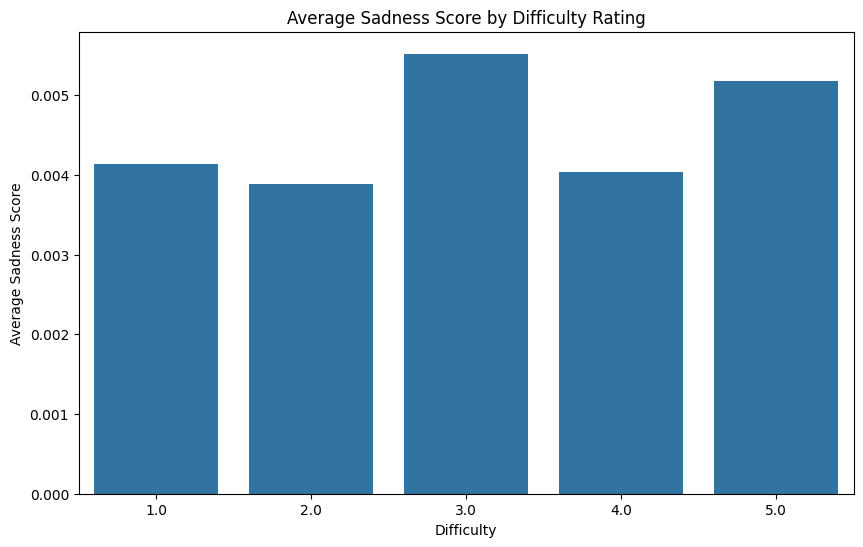

ANOVA Table for sadness based on Quality:
               sum_sq      df         F    PR(>F)
C(Quality)   0.034335     8.0  2.565518  0.008572
Residual    16.715774  9992.0       NaN       NaN

Regression Summary for sadness based on Quality:
                            OLS Regression Results                            
Dep. Variable:                sadness   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.566
Date:                Mon, 03 Jun 2024   Prob (F-statistic):            0.00857
Time:                        00:02:45   Log-Likelihood:                 17783.
No. Observations:               10001   AIC:                        -3.555e+04
Df Residuals:                    9992   BIC:                        -3.548e+04
Df Model:                           8                                         
Covariance Type:            nonrobust          

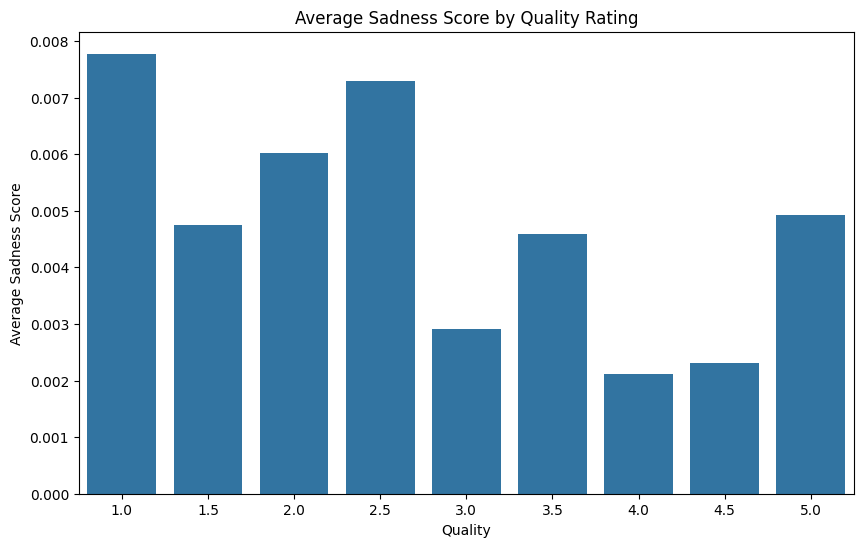

ANOVA Table for nervousness based on Difficulty:
                 sum_sq      df         F   PR(>F)
C(Difficulty)  0.000142     4.0  1.552197  0.18418
Residual       0.228498  9996.0       NaN      NaN

Regression Summary for nervousness based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:            nervousness   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.552
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.184
Time:                        00:02:45   Log-Likelihood:                 39248.
No. Observations:               10001   AIC:                        -7.849e+04
Df Residuals:                    9996   BIC:                        -7.845e+04
Df Model:                           4                                         
Covariance Type:            no

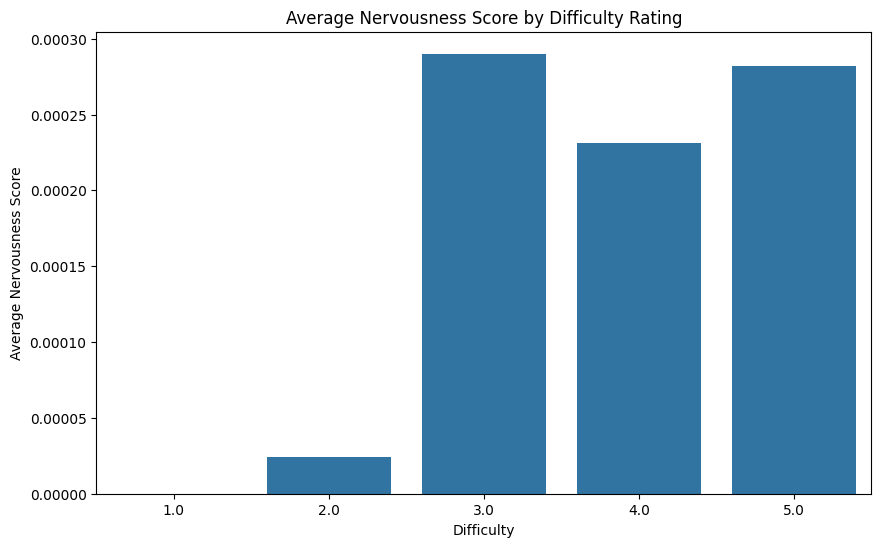

ANOVA Table for nervousness based on Quality:
              sum_sq      df         F    PR(>F)
C(Quality)  0.000178     8.0  0.971888  0.455811
Residual    0.228462  9992.0       NaN       NaN

Regression Summary for nervousness based on Quality:
                            OLS Regression Results                            
Dep. Variable:            nervousness   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9719
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.456
Time:                        00:02:45   Log-Likelihood:                 39249.
No. Observations:               10001   AIC:                        -7.848e+04
Df Residuals:                    9992   BIC:                        -7.841e+04
Df Model:                           8                                         
Covariance Type:            nonrobust     

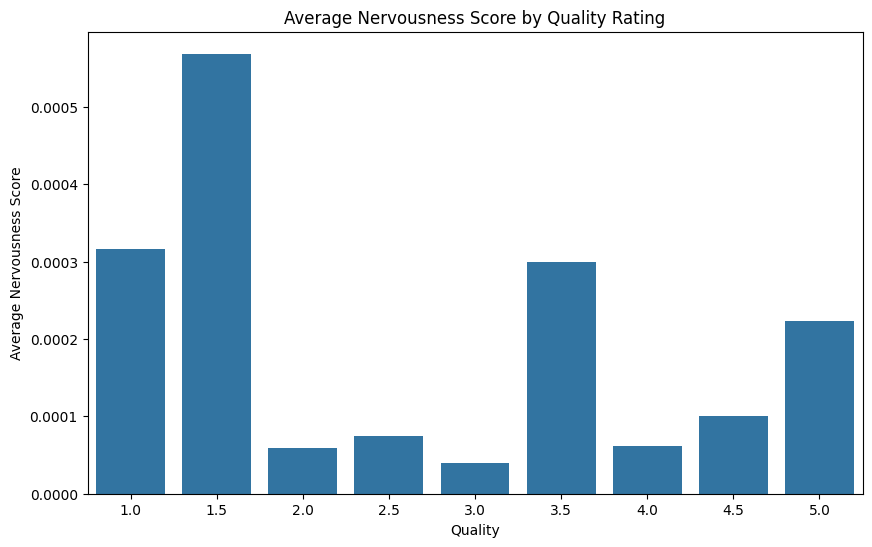

ANOVA Table for fear based on Difficulty:
                  sum_sq      df         F        PR(>F)
C(Difficulty)   0.161829     4.0  18.58326  3.140905e-15
Residual       21.762098  9996.0       NaN           NaN

Regression Summary for fear based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                   fear   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     18.58
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           3.14e-15
Time:                        00:02:46   Log-Likelihood:                 16464.
No. Observations:               10001   AIC:                        -3.292e+04
Df Residuals:                    9996   BIC:                        -3.288e+04
Df Model:                           4                                         
Covariance Type:          

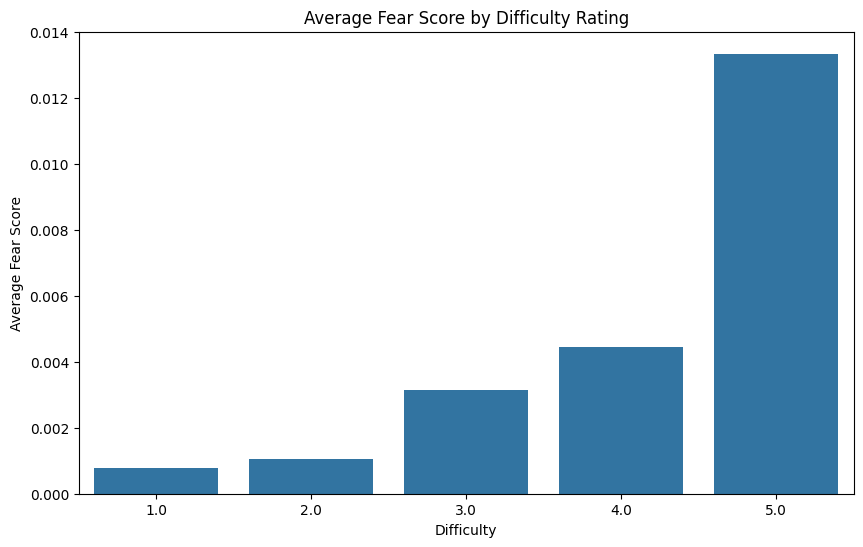

ANOVA Table for fear based on Quality:
               sum_sq      df          F        PR(>F)
C(Quality)   0.283770     8.0  16.378315  2.554462e-24
Residual    21.640157  9992.0        NaN           NaN

Regression Summary for fear based on Quality:
                            OLS Regression Results                            
Dep. Variable:                   fear   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     16.38
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           2.55e-24
Time:                        00:02:46   Log-Likelihood:                 16492.
No. Observations:               10001   AIC:                        -3.297e+04
Df Residuals:                    9992   BIC:                        -3.290e+04
Df Model:                           8                                         
Covariance Type:            nonrobust 

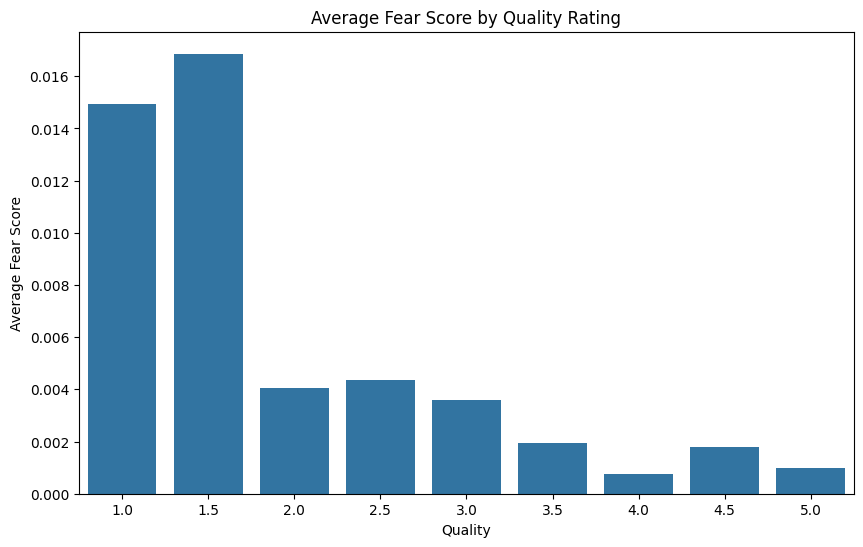

ANOVA Table for embarrassment based on Difficulty:
                 sum_sq      df         F   PR(>F)
C(Difficulty)  0.001064     4.0  1.239646  0.29165
Residual       2.144563  9996.0       NaN      NaN

Regression Summary for embarrassment based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:          embarrassment   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.240
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.292
Time:                        00:02:46   Log-Likelihood:                 28051.
No. Observations:               10001   AIC:                        -5.609e+04
Df Residuals:                    9996   BIC:                        -5.606e+04
Df Model:                           4                                         
Covariance Type:          

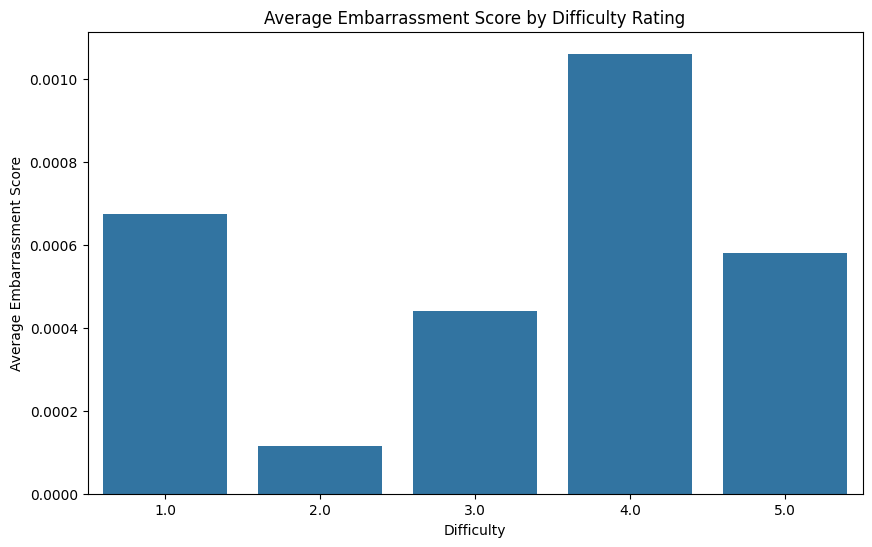

ANOVA Table for embarrassment based on Quality:
              sum_sq      df         F    PR(>F)
C(Quality)  0.002531     8.0  1.475045  0.160496
Residual    2.143096  9992.0       NaN       NaN

Regression Summary for embarrassment based on Quality:
                            OLS Regression Results                            
Dep. Variable:          embarrassment   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.475
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.160
Time:                        00:02:46   Log-Likelihood:                 28054.
No. Observations:               10001   AIC:                        -5.609e+04
Df Residuals:                    9992   BIC:                        -5.603e+04
Df Model:                           8                                         
Covariance Type:            nonrobust 

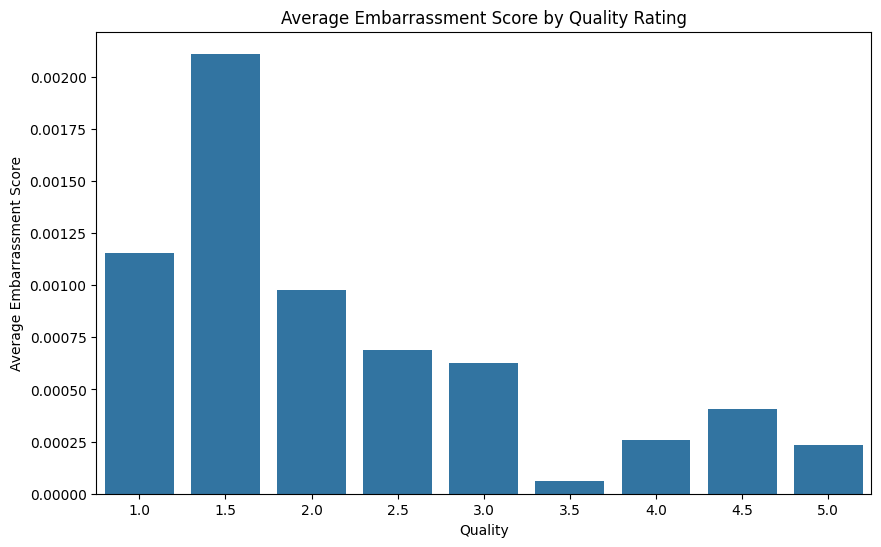

ANOVA Table for surprise based on Difficulty:
                  sum_sq      df         F    PR(>F)
C(Difficulty)   0.005128     4.0  1.213542  0.302665
Residual       10.560888  9996.0       NaN       NaN

Regression Summary for surprise based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:               surprise   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.214
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.303
Time:                        00:02:46   Log-Likelihood:                 20079.
No. Observations:               10001   AIC:                        -4.015e+04
Df Residuals:                    9996   BIC:                        -4.011e+04
Df Model:                           4                                         
Covariance Type:            no

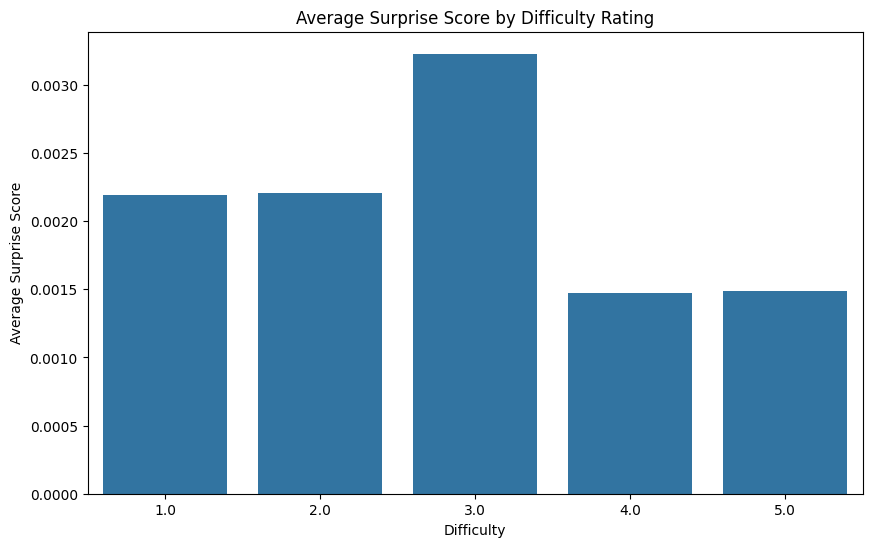

ANOVA Table for surprise based on Quality:
               sum_sq      df         F    PR(>F)
C(Quality)   0.011981     8.0  1.417929  0.183147
Residual    10.554035  9992.0       NaN       NaN

Regression Summary for surprise based on Quality:
                            OLS Regression Results                            
Dep. Variable:               surprise   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.418
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.183
Time:                        00:02:47   Log-Likelihood:                 20082.
No. Observations:               10001   AIC:                        -4.015e+04
Df Residuals:                    9992   BIC:                        -4.008e+04
Df Model:                           8                                         
Covariance Type:            nonrobust        

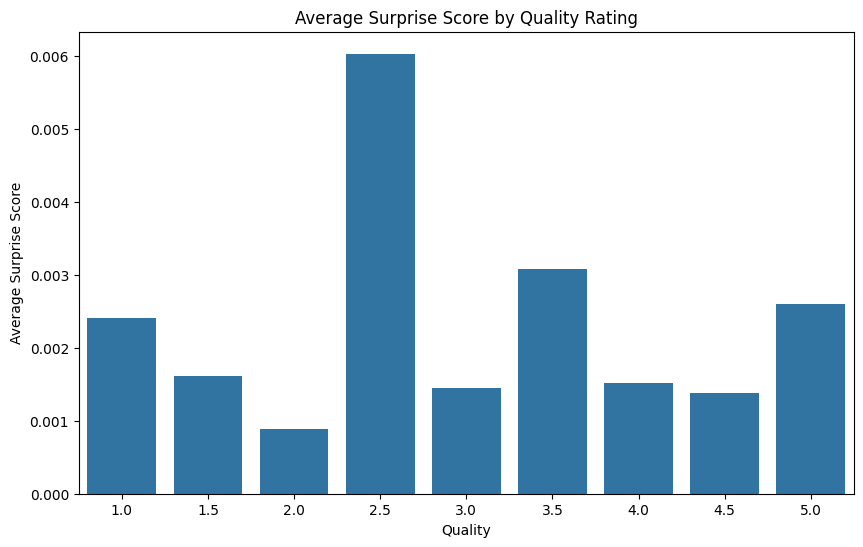

ANOVA Table for grief based on Difficulty:
                 sum_sq      df         F    PR(>F)
C(Difficulty)  0.000001     4.0  0.399804  0.808927
Residual       0.006414  9996.0       NaN       NaN

Regression Summary for grief based on Difficulty:
                            OLS Regression Results                            
Dep. Variable:                  grief   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3998
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.809
Time:                        00:02:47   Log-Likelihood:                 57115.
No. Observations:               10001   AIC:                        -1.142e+05
Df Residuals:                    9996   BIC:                        -1.142e+05
Df Model:                           4                                         
Covariance Type:            nonrobust  

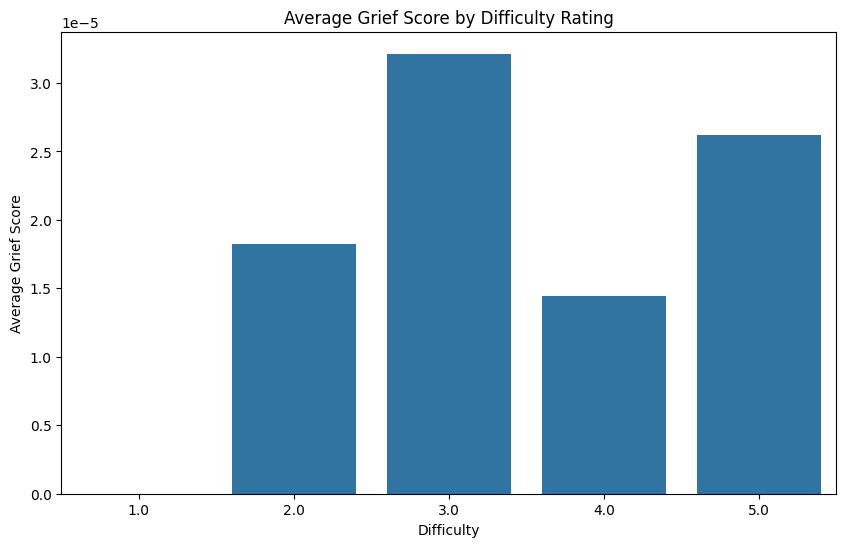

ANOVA Table for grief based on Quality:
              sum_sq      df         F    PR(>F)
C(Quality)  0.000006     8.0  1.114837  0.349312
Residual    0.006409  9992.0       NaN       NaN

Regression Summary for grief based on Quality:
                            OLS Regression Results                            
Dep. Variable:                  grief   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.115
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.349
Time:                        00:02:47   Log-Likelihood:                 57118.
No. Observations:               10001   AIC:                        -1.142e+05
Df Residuals:                    9992   BIC:                        -1.142e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                 

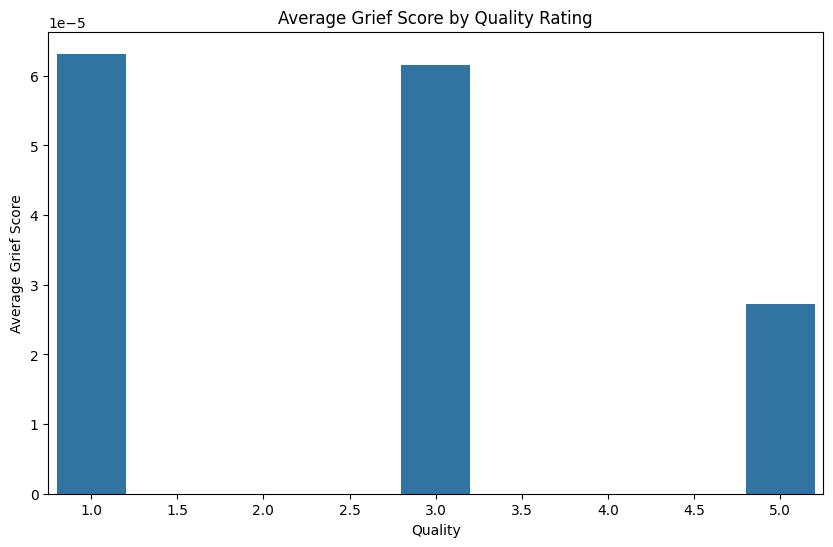

In [64]:
import pandas as pd
from transformers import pipeline
from concurrent.futures import ThreadPoolExecutor, as_completed
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset into a Pandas DataFrame
cmv_df = pd.read_csv('Cleaned_UW_RMP.csv')

# Initialize the text classification pipeline with GPU support
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=5, device=0)

# Function to process a batch of texts
def process_batch(batch_comments):
    outputs = classifier(batch_comments)
    emotion_scores = []
    for output in outputs:
        score_dict = {label['label']: label['score'] for label in output}
        emotion_scores.append(score_dict)
    return emotion_scores

# Batch processing with parallel execution
batch_size = 32  # Adjust the batch size according to your memory capacity
comments = cmv_df['Review-Body'].dropna().tolist()
batches = [comments[i:i + batch_size] for i in range(0, len(comments), batch_size)]

all_emotion_scores = []
with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust number of workers based on your environment
    futures = {executor.submit(process_batch, batch): batch for batch in batches}
    for future in as_completed(futures):
        batch_emotion_scores = future.result()
        all_emotion_scores.extend(batch_emotion_scores)

# Create a DataFrame with emotion scores
emotion_scores_df = pd.DataFrame(all_emotion_scores)

# Add difficulty and quality ratings to the DataFrame
cmv_df = cmv_df.dropna(subset=['Review-Body']).reset_index(drop=True)
emotion_scores_df['Difficulty'] = cmv_df['Difficulty']
emotion_scores_df['Quality'] = cmv_df['Quality']

# Function to analyze emotions and plot graphs
def analyze_emotion(emotion, rating_type):
    emotion_scores_df[emotion] = emotion_scores_df[emotion].fillna(0)
    model = ols(f'{emotion} ~ C({rating_type})', data=emotion_scores_df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    print(f"ANOVA Table for {emotion} based on {rating_type}:")
    print(anova_table)

    print(f"\nRegression Summary for {emotion} based on {rating_type}:")
    print(model.summary())

    # Aggregate emotion scores by rating
    avg_emotion_by_rating = emotion_scores_df.groupby(rating_type)[emotion].mean().reset_index()

    print(f"\nAverage {emotion.capitalize()} Score by {rating_type.capitalize()} Rating:")
    print(avg_emotion_by_rating)
    print("\n" + "="*80 + "\n")

    # Plotting the results
    plt.figure(figsize=(10, 6))
    sns.barplot(x=rating_type, y=emotion, data=avg_emotion_by_rating)
    plt.title(f'Average {emotion.capitalize()} Score by {rating_type.capitalize()} Rating')
    plt.xlabel(rating_type.capitalize())
    plt.ylabel(f'Average {emotion.capitalize()} Score')
    plt.show()

# List of emotions to analyze
emotions = emotion_scores_df.columns[:-2]  # Exclude 'Difficulty' and 'Quality' columns

# Analyze each emotion for difficulty and quality
for emotion in emotions:
    analyze_emotion(emotion, 'Difficulty')
    analyze_emotion(emotion, 'Quality')